<a href="https://colab.research.google.com/github/rajagopalmotivate/DeepLearnIITMA1/blob/master/DCGAN_with_2_different_generators_and_1_Classifier_Good_Nandri_ver11%20int1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is ensemble of 2 identical G

this step is to train each G seperately 

once each G generates meaniful results, then ensemble them

the way to train seperate is 
1) seperate train and load weights 
2) train with Avg (same G)


In [1]:
from IPython.display import Image
from keras.utils import plot_model
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Double check with Python 3


In [0]:
# Restart runtime to allow Jupyter to know the changes above
import os
os._exit(0)

In [0]:
from IPython.display import Image
from keras.utils import plot_model

In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

Using TensorFlow backend.


In [0]:
def load_dataold():
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
##X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:


def plotamodel(amodel, showdetails=True):
  # Model summary
  print(amodel.summary())

  if (showdetails==True):
    # Plot model graph
    plot_model(amodel, show_shapes=True, show_layer_names=True, to_file='model.png')
    Image(retina=True, filename='model.png')
  if (showdetails==False):
    # Plot model graph
    plot_model(amodel, show_shapes=False, show_layer_names=False, to_file='modelsmall.png')
    Image(retina=True, filename='modelsmall.png')

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(2)

    num_examples = X_train.shape[0] / 2
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
            noise2 = copy.deepcopy(noise1)
            fake_images3 = mergedmodel.predict(noise2)
            fake_labels3 = np.zeros((half_batch, 1))            
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            if modeltotrain == 2:
              fake_images = fake_images2
              fake_labels = fake_labels2
            if modeltotrain == 3:
              fake_images = fake_images3
              fake_labels = fake_labels3              
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs(generator1, epoch, batch)
            if batch % 101 == 0:
                 save_imgs(generator2, epoch, batch)
            if batch % 102 == 0:
                 save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNEW(averagemode = 1, loadpretrainedweights=False):
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    if(averagemode == 1):
          models = [generator1, generator1]
    if(averagemode == 2):
          models = [generator2, generator2]
    if(averagemode == 3):
          models = [generator1, generator2]


  ##  models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        

    
    if(loadpretrainedweights==True):
    #  generator1 = generator1.load_weights('generatorTrainedepoch2.h5')
    #  generator2 = generator2.load_weights('generator2Trainedepoch2.h5')
      generator1 = load_model('generator1fmnist.h5')
      generator2 = load_model('generator2fmnist.h5')
      

    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer) 
  
    #plotamodel(mergedmodel)
    plotamodel(combined)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [11]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 1 ,  loadpretrainedweights=False)


    
    

    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          

Number of examples:  30000.0
Number of Batches:  937
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/937 [D loss: 0.992873, acc.: 25.00%] [G loss: 0.829391]


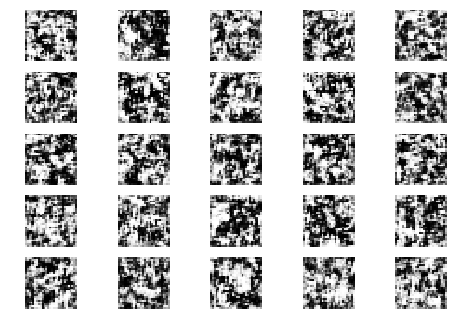

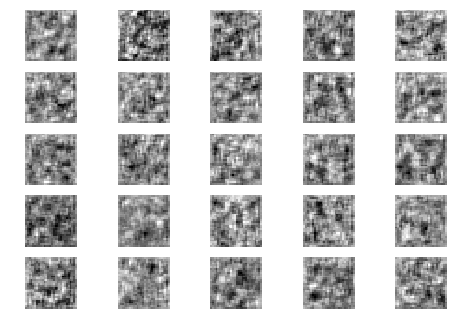

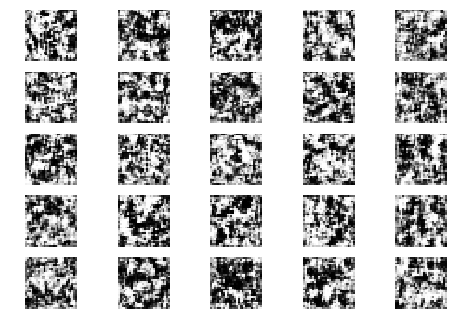

Epoch 0 Batch 1/937 [D loss: 0.786204, acc.: 56.25%] [G loss: 0.824057]
Epoch 0 Batch 2/937 [D loss: 0.699552, acc.: 53.12%] [G loss: 0.764487]
Epoch 0 Batch 3/937 [D loss: 0.529648, acc.: 68.75%] [G loss: 0.898661]
Epoch 0 Batch 4/937 [D loss: 0.531205, acc.: 75.00%] [G loss: 1.056485]
Epoch 0 Batch 5/937 [D loss: 0.553660, acc.: 78.12%] [G loss: 1.185057]
Epoch 0 Batch 6/937 [D loss: 0.387560, acc.: 87.50%] [G loss: 1.375919]
Epoch 0 Batch 7/937 [D loss: 0.474408, acc.: 78.12%] [G loss: 1.215927]
Epoch 0 Batch 8/937 [D loss: 0.379891, acc.: 84.38%] [G loss: 1.383200]
Epoch 0 Batch 9/937 [D loss: 0.423293, acc.: 81.25%] [G loss: 1.437942]
Epoch 0 Batch 10/937 [D loss: 0.446328, acc.: 81.25%] [G loss: 1.404841]
Epoch 0 Batch 11/937 [D loss: 0.430483, acc.: 84.38%] [G loss: 1.302772]
Epoch 0 Batch 12/937 [D loss: 0.360054, acc.: 93.75%] [G loss: 1.550943]
Epoch 0 Batch 13/937 [D loss: 0.663600, acc.: 62.50%] [G loss: 1.336079]
Epoch 0 Batch 14/937 [D loss: 0.418889, acc.: 81.25%] [G los

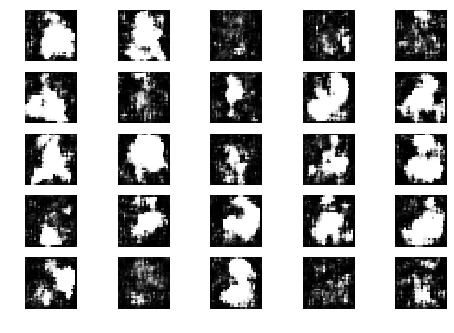

Epoch 0 Batch 101/937 [D loss: 0.395353, acc.: 81.25%] [G loss: 1.607046]


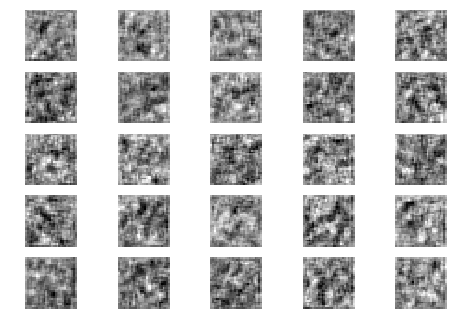

Epoch 0 Batch 102/937 [D loss: 0.293028, acc.: 90.62%] [G loss: 2.000564]


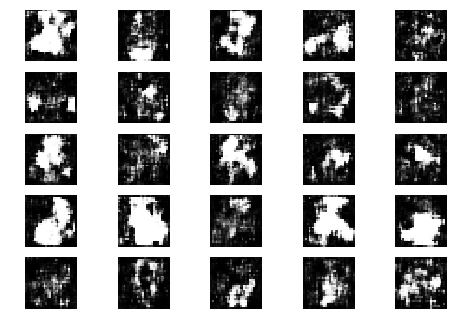

Epoch 0 Batch 103/937 [D loss: 0.391490, acc.: 87.50%] [G loss: 2.169607]
Epoch 0 Batch 104/937 [D loss: 0.473838, acc.: 78.12%] [G loss: 1.806509]
Epoch 0 Batch 105/937 [D loss: 0.611535, acc.: 71.88%] [G loss: 2.689263]
Epoch 0 Batch 106/937 [D loss: 0.290447, acc.: 93.75%] [G loss: 2.118169]
Epoch 0 Batch 107/937 [D loss: 0.711447, acc.: 59.38%] [G loss: 2.094161]
Epoch 0 Batch 108/937 [D loss: 0.459304, acc.: 75.00%] [G loss: 2.050874]
Epoch 0 Batch 109/937 [D loss: 0.746897, acc.: 65.62%] [G loss: 2.063362]
Epoch 0 Batch 110/937 [D loss: 0.412024, acc.: 84.38%] [G loss: 1.681466]
Epoch 0 Batch 111/937 [D loss: 0.417844, acc.: 78.12%] [G loss: 2.255490]
Epoch 0 Batch 112/937 [D loss: 0.595454, acc.: 78.12%] [G loss: 1.653517]
Epoch 0 Batch 113/937 [D loss: 0.582994, acc.: 59.38%] [G loss: 2.266114]
Epoch 0 Batch 114/937 [D loss: 0.562520, acc.: 75.00%] [G loss: 1.806673]
Epoch 0 Batch 115/937 [D loss: 0.340731, acc.: 75.00%] [G loss: 1.728100]
Epoch 0 Batch 116/937 [D loss: 0.32879

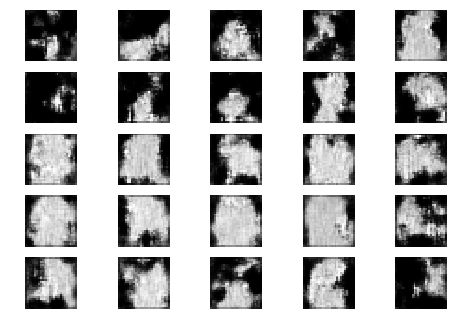

Epoch 0 Batch 201/937 [D loss: 0.529583, acc.: 68.75%] [G loss: 1.005086]
Epoch 0 Batch 202/937 [D loss: 0.784964, acc.: 56.25%] [G loss: 1.702654]


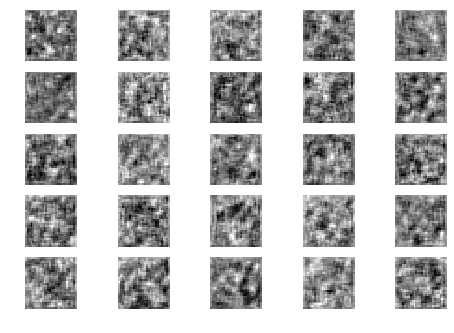

Epoch 0 Batch 203/937 [D loss: 0.694990, acc.: 59.38%] [G loss: 1.883200]
Epoch 0 Batch 204/937 [D loss: 0.528144, acc.: 71.88%] [G loss: 1.736812]


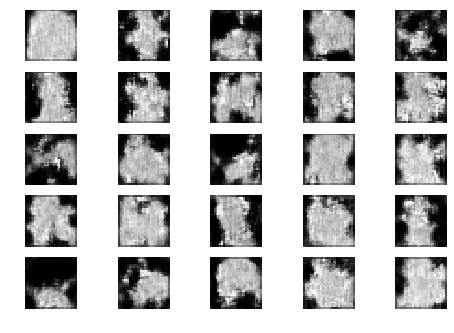

Epoch 0 Batch 205/937 [D loss: 0.649341, acc.: 62.50%] [G loss: 1.242428]
Epoch 0 Batch 206/937 [D loss: 0.851154, acc.: 59.38%] [G loss: 1.268307]
Epoch 0 Batch 207/937 [D loss: 0.549136, acc.: 68.75%] [G loss: 1.256815]
Epoch 0 Batch 208/937 [D loss: 0.543588, acc.: 78.12%] [G loss: 1.598130]
Epoch 0 Batch 209/937 [D loss: 0.820218, acc.: 59.38%] [G loss: 1.514899]
Epoch 0 Batch 210/937 [D loss: 0.695204, acc.: 59.38%] [G loss: 1.865627]
Epoch 0 Batch 211/937 [D loss: 0.790795, acc.: 56.25%] [G loss: 1.457916]
Epoch 0 Batch 212/937 [D loss: 0.481035, acc.: 78.12%] [G loss: 1.487385]
Epoch 0 Batch 213/937 [D loss: 0.494849, acc.: 68.75%] [G loss: 1.994509]
Epoch 0 Batch 214/937 [D loss: 0.744207, acc.: 59.38%] [G loss: 1.586434]
Epoch 0 Batch 215/937 [D loss: 0.703764, acc.: 56.25%] [G loss: 1.413127]
Epoch 0 Batch 216/937 [D loss: 0.435131, acc.: 78.12%] [G loss: 1.653188]
Epoch 0 Batch 217/937 [D loss: 0.598308, acc.: 75.00%] [G loss: 1.571390]
Epoch 0 Batch 218/937 [D loss: 0.53615

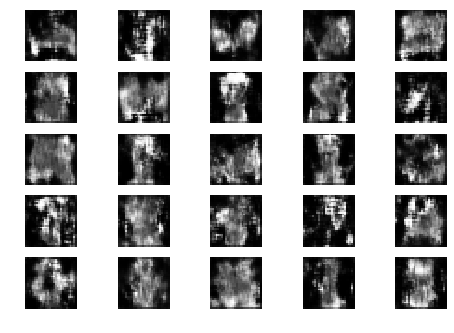

Epoch 0 Batch 301/937 [D loss: 0.632770, acc.: 59.38%] [G loss: 1.488159]
Epoch 0 Batch 302/937 [D loss: 0.637476, acc.: 75.00%] [G loss: 1.283298]
Epoch 0 Batch 303/937 [D loss: 0.851613, acc.: 56.25%] [G loss: 1.130200]


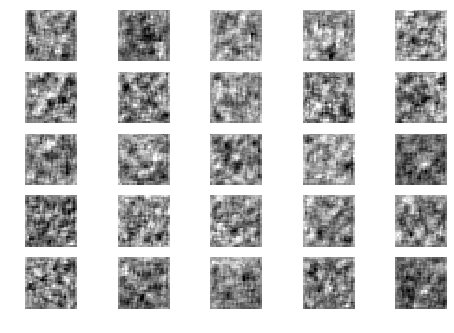

Epoch 0 Batch 304/937 [D loss: 0.661895, acc.: 59.38%] [G loss: 1.188189]
Epoch 0 Batch 305/937 [D loss: 0.833682, acc.: 56.25%] [G loss: 1.183256]
Epoch 0 Batch 306/937 [D loss: 0.786005, acc.: 56.25%] [G loss: 1.210448]


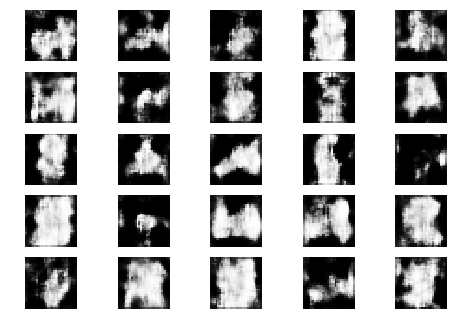

Epoch 0 Batch 307/937 [D loss: 0.663882, acc.: 59.38%] [G loss: 1.342539]
Epoch 0 Batch 308/937 [D loss: 0.753916, acc.: 53.12%] [G loss: 1.578422]
Epoch 0 Batch 309/937 [D loss: 0.777393, acc.: 50.00%] [G loss: 1.452731]
Epoch 0 Batch 310/937 [D loss: 0.658270, acc.: 65.62%] [G loss: 1.257671]
Epoch 0 Batch 311/937 [D loss: 0.848550, acc.: 50.00%] [G loss: 1.397900]
Epoch 0 Batch 312/937 [D loss: 0.857202, acc.: 56.25%] [G loss: 1.311834]
Epoch 0 Batch 313/937 [D loss: 0.769713, acc.: 46.88%] [G loss: 0.891758]
Epoch 0 Batch 314/937 [D loss: 0.597940, acc.: 71.88%] [G loss: 1.557211]
Epoch 0 Batch 315/937 [D loss: 0.731363, acc.: 62.50%] [G loss: 1.513085]
Epoch 0 Batch 316/937 [D loss: 0.475689, acc.: 81.25%] [G loss: 1.542813]
Epoch 0 Batch 317/937 [D loss: 0.527954, acc.: 75.00%] [G loss: 1.264351]
Epoch 0 Batch 318/937 [D loss: 0.742079, acc.: 53.12%] [G loss: 1.380777]
Epoch 0 Batch 319/937 [D loss: 0.619429, acc.: 68.75%] [G loss: 1.100901]
Epoch 0 Batch 320/937 [D loss: 0.65257

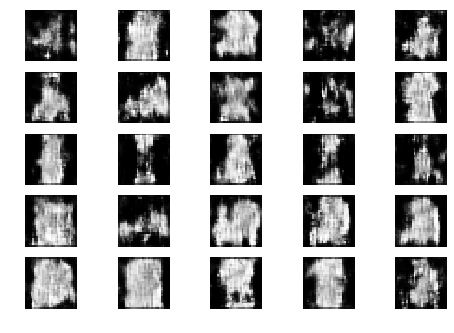

Epoch 0 Batch 401/937 [D loss: 0.717822, acc.: 62.50%] [G loss: 0.951800]
Epoch 0 Batch 402/937 [D loss: 0.524930, acc.: 65.62%] [G loss: 1.461002]
Epoch 0 Batch 403/937 [D loss: 0.930817, acc.: 46.88%] [G loss: 1.308728]
Epoch 0 Batch 404/937 [D loss: 0.638323, acc.: 59.38%] [G loss: 1.362552]


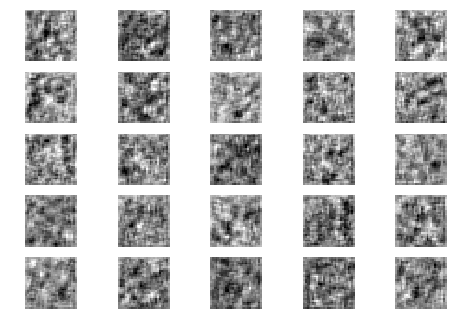

Epoch 0 Batch 405/937 [D loss: 0.911012, acc.: 40.62%] [G loss: 1.244129]
Epoch 0 Batch 406/937 [D loss: 0.706330, acc.: 59.38%] [G loss: 1.339021]
Epoch 0 Batch 407/937 [D loss: 0.650862, acc.: 59.38%] [G loss: 1.265423]
Epoch 0 Batch 408/937 [D loss: 0.579195, acc.: 65.62%] [G loss: 0.997296]


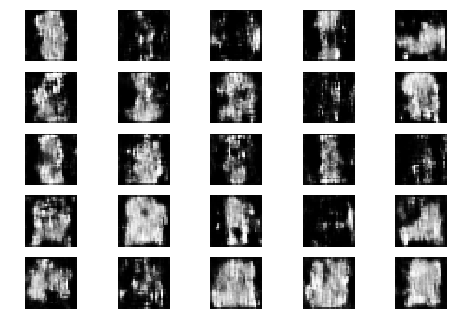

Epoch 0 Batch 409/937 [D loss: 0.550748, acc.: 75.00%] [G loss: 1.424898]
Epoch 0 Batch 410/937 [D loss: 0.687316, acc.: 56.25%] [G loss: 1.280870]
Epoch 0 Batch 411/937 [D loss: 0.415983, acc.: 78.12%] [G loss: 1.414068]
Epoch 0 Batch 412/937 [D loss: 0.816439, acc.: 46.88%] [G loss: 1.156483]
Epoch 0 Batch 413/937 [D loss: 0.640835, acc.: 65.62%] [G loss: 1.295259]
Epoch 0 Batch 414/937 [D loss: 0.666997, acc.: 59.38%] [G loss: 1.361442]
Epoch 0 Batch 415/937 [D loss: 0.860893, acc.: 50.00%] [G loss: 1.166977]
Epoch 0 Batch 416/937 [D loss: 0.529385, acc.: 62.50%] [G loss: 1.089241]
Epoch 0 Batch 417/937 [D loss: 0.804332, acc.: 56.25%] [G loss: 1.190565]
Epoch 0 Batch 418/937 [D loss: 0.616725, acc.: 65.62%] [G loss: 1.480184]
Epoch 0 Batch 419/937 [D loss: 0.619349, acc.: 68.75%] [G loss: 1.157399]
Epoch 0 Batch 420/937 [D loss: 0.617361, acc.: 65.62%] [G loss: 1.082230]
Epoch 0 Batch 421/937 [D loss: 0.662587, acc.: 59.38%] [G loss: 1.411758]
Epoch 0 Batch 422/937 [D loss: 0.76182

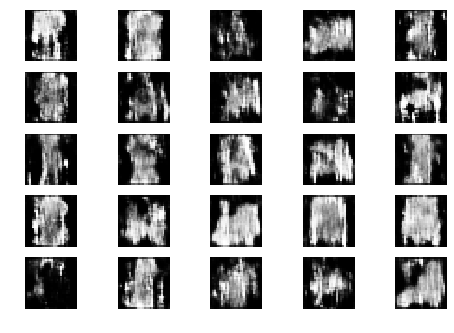

Epoch 0 Batch 501/937 [D loss: 0.738629, acc.: 59.38%] [G loss: 1.232619]
Epoch 0 Batch 502/937 [D loss: 0.551493, acc.: 71.88%] [G loss: 1.177108]
Epoch 0 Batch 503/937 [D loss: 0.547528, acc.: 68.75%] [G loss: 1.430223]
Epoch 0 Batch 504/937 [D loss: 0.464856, acc.: 71.88%] [G loss: 1.258504]
Epoch 0 Batch 505/937 [D loss: 0.709094, acc.: 59.38%] [G loss: 1.062400]


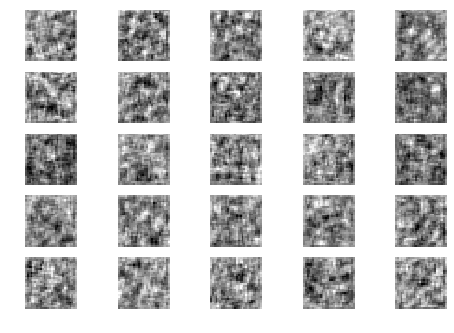

Epoch 0 Batch 506/937 [D loss: 0.637285, acc.: 68.75%] [G loss: 1.503307]
Epoch 0 Batch 507/937 [D loss: 0.514795, acc.: 68.75%] [G loss: 1.658732]
Epoch 0 Batch 508/937 [D loss: 0.718820, acc.: 59.38%] [G loss: 1.369406]
Epoch 0 Batch 509/937 [D loss: 0.637416, acc.: 56.25%] [G loss: 1.447430]
Epoch 0 Batch 510/937 [D loss: 0.626609, acc.: 59.38%] [G loss: 1.276437]


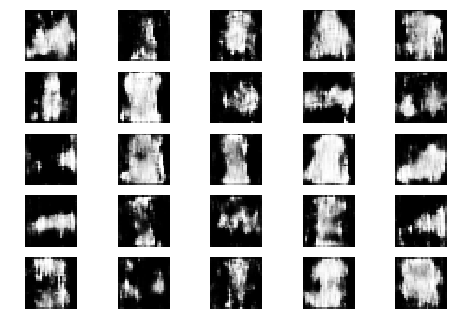

Epoch 0 Batch 511/937 [D loss: 0.612278, acc.: 65.62%] [G loss: 1.034461]
Epoch 0 Batch 512/937 [D loss: 0.661042, acc.: 65.62%] [G loss: 1.554272]
Epoch 0 Batch 513/937 [D loss: 0.665725, acc.: 75.00%] [G loss: 1.056469]
Epoch 0 Batch 514/937 [D loss: 0.573906, acc.: 68.75%] [G loss: 1.425171]
Epoch 0 Batch 515/937 [D loss: 0.420503, acc.: 81.25%] [G loss: 1.609618]
Epoch 0 Batch 516/937 [D loss: 0.555045, acc.: 71.88%] [G loss: 1.385797]
Epoch 0 Batch 517/937 [D loss: 0.594711, acc.: 56.25%] [G loss: 1.361595]
Epoch 0 Batch 518/937 [D loss: 0.525469, acc.: 75.00%] [G loss: 1.240844]
Epoch 0 Batch 519/937 [D loss: 0.648911, acc.: 62.50%] [G loss: 1.088272]
Epoch 0 Batch 520/937 [D loss: 0.549253, acc.: 75.00%] [G loss: 1.587720]
Epoch 0 Batch 521/937 [D loss: 0.689838, acc.: 62.50%] [G loss: 1.318620]
Epoch 0 Batch 522/937 [D loss: 0.588197, acc.: 68.75%] [G loss: 1.564892]
Epoch 0 Batch 523/937 [D loss: 0.640182, acc.: 68.75%] [G loss: 1.294544]
Epoch 0 Batch 524/937 [D loss: 0.57977

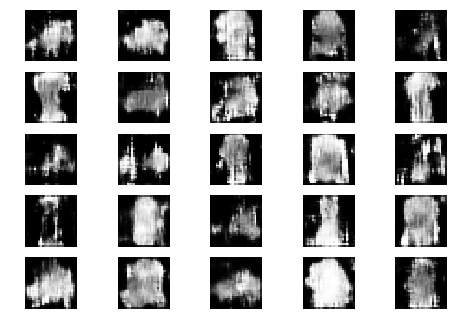

Epoch 0 Batch 601/937 [D loss: 0.696361, acc.: 56.25%] [G loss: 1.207329]
Epoch 0 Batch 602/937 [D loss: 0.679757, acc.: 62.50%] [G loss: 1.464345]
Epoch 0 Batch 603/937 [D loss: 0.598493, acc.: 68.75%] [G loss: 1.616811]
Epoch 0 Batch 604/937 [D loss: 0.742666, acc.: 46.88%] [G loss: 1.387260]
Epoch 0 Batch 605/937 [D loss: 0.566734, acc.: 81.25%] [G loss: 1.399736]
Epoch 0 Batch 606/937 [D loss: 0.406657, acc.: 87.50%] [G loss: 1.511014]


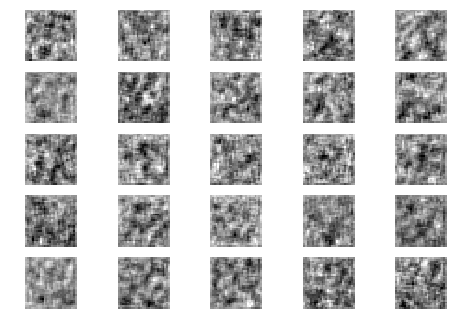

Epoch 0 Batch 607/937 [D loss: 0.445304, acc.: 78.12%] [G loss: 1.187705]
Epoch 0 Batch 608/937 [D loss: 0.516956, acc.: 75.00%] [G loss: 1.427090]
Epoch 0 Batch 609/937 [D loss: 0.525037, acc.: 71.88%] [G loss: 1.534562]
Epoch 0 Batch 610/937 [D loss: 0.796885, acc.: 50.00%] [G loss: 1.358949]
Epoch 0 Batch 611/937 [D loss: 0.432645, acc.: 84.38%] [G loss: 1.035619]
Epoch 0 Batch 612/937 [D loss: 0.705693, acc.: 68.75%] [G loss: 1.177397]


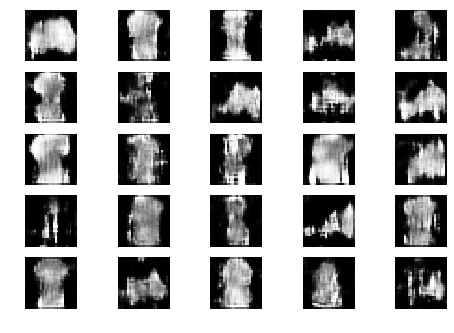

Epoch 0 Batch 613/937 [D loss: 0.612220, acc.: 65.62%] [G loss: 1.230901]
Epoch 0 Batch 614/937 [D loss: 0.547837, acc.: 68.75%] [G loss: 1.268771]
Epoch 0 Batch 615/937 [D loss: 0.738621, acc.: 62.50%] [G loss: 1.316681]
Epoch 0 Batch 616/937 [D loss: 0.808747, acc.: 56.25%] [G loss: 1.218571]
Epoch 0 Batch 617/937 [D loss: 0.702583, acc.: 62.50%] [G loss: 1.074269]
Epoch 0 Batch 618/937 [D loss: 0.680832, acc.: 56.25%] [G loss: 1.012540]
Epoch 0 Batch 619/937 [D loss: 0.525659, acc.: 75.00%] [G loss: 1.305738]
Epoch 0 Batch 620/937 [D loss: 0.661620, acc.: 59.38%] [G loss: 1.580956]
Epoch 0 Batch 621/937 [D loss: 0.658492, acc.: 59.38%] [G loss: 1.221554]
Epoch 0 Batch 622/937 [D loss: 0.681884, acc.: 59.38%] [G loss: 1.402690]
Epoch 0 Batch 623/937 [D loss: 0.839522, acc.: 53.12%] [G loss: 0.987585]
Epoch 0 Batch 624/937 [D loss: 0.612500, acc.: 62.50%] [G loss: 1.191280]
Epoch 0 Batch 625/937 [D loss: 0.694426, acc.: 53.12%] [G loss: 1.162706]
Epoch 0 Batch 626/937 [D loss: 0.50100

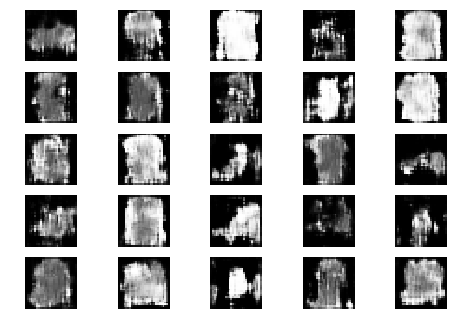

Epoch 0 Batch 701/937 [D loss: 0.738808, acc.: 53.12%] [G loss: 1.159353]
Epoch 0 Batch 702/937 [D loss: 0.606591, acc.: 68.75%] [G loss: 1.051116]
Epoch 0 Batch 703/937 [D loss: 0.778515, acc.: 56.25%] [G loss: 1.386755]
Epoch 0 Batch 704/937 [D loss: 0.557297, acc.: 68.75%] [G loss: 1.288437]
Epoch 0 Batch 705/937 [D loss: 0.704941, acc.: 65.62%] [G loss: 1.286709]
Epoch 0 Batch 706/937 [D loss: 0.604369, acc.: 68.75%] [G loss: 1.505464]
Epoch 0 Batch 707/937 [D loss: 0.667302, acc.: 65.62%] [G loss: 1.342031]


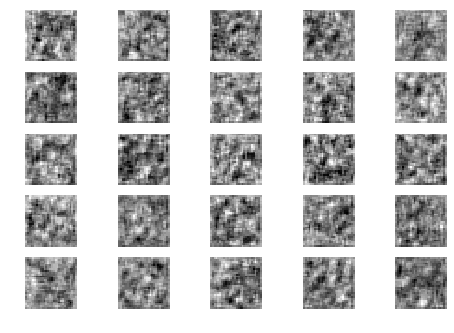

Epoch 0 Batch 708/937 [D loss: 0.577089, acc.: 65.62%] [G loss: 1.665272]
Epoch 0 Batch 709/937 [D loss: 0.770893, acc.: 59.38%] [G loss: 0.970383]
Epoch 0 Batch 710/937 [D loss: 0.630000, acc.: 65.62%] [G loss: 1.203998]
Epoch 0 Batch 711/937 [D loss: 0.618555, acc.: 68.75%] [G loss: 1.283027]
Epoch 0 Batch 712/937 [D loss: 0.534929, acc.: 65.62%] [G loss: 1.315611]
Epoch 0 Batch 713/937 [D loss: 0.472949, acc.: 68.75%] [G loss: 1.285752]
Epoch 0 Batch 714/937 [D loss: 0.760884, acc.: 53.12%] [G loss: 1.131365]


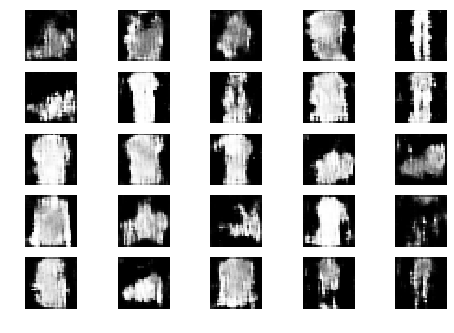

Epoch 0 Batch 715/937 [D loss: 0.524844, acc.: 71.88%] [G loss: 1.274253]
Epoch 0 Batch 716/937 [D loss: 0.613961, acc.: 71.88%] [G loss: 1.428365]
Epoch 0 Batch 717/937 [D loss: 0.627404, acc.: 65.62%] [G loss: 1.257818]
Epoch 0 Batch 718/937 [D loss: 0.508476, acc.: 71.88%] [G loss: 1.337604]
Epoch 0 Batch 719/937 [D loss: 0.565224, acc.: 68.75%] [G loss: 1.182979]
Epoch 0 Batch 720/937 [D loss: 0.731703, acc.: 56.25%] [G loss: 1.265948]
Epoch 0 Batch 721/937 [D loss: 0.614733, acc.: 65.62%] [G loss: 1.329867]
Epoch 0 Batch 722/937 [D loss: 0.634676, acc.: 62.50%] [G loss: 1.482037]
Epoch 0 Batch 723/937 [D loss: 0.791671, acc.: 46.88%] [G loss: 1.021273]
Epoch 0 Batch 724/937 [D loss: 0.595531, acc.: 65.62%] [G loss: 1.380367]
Epoch 0 Batch 725/937 [D loss: 0.711116, acc.: 56.25%] [G loss: 1.241147]
Epoch 0 Batch 726/937 [D loss: 0.531143, acc.: 65.62%] [G loss: 1.244639]
Epoch 0 Batch 727/937 [D loss: 0.613219, acc.: 62.50%] [G loss: 1.445520]
Epoch 0 Batch 728/937 [D loss: 0.58024

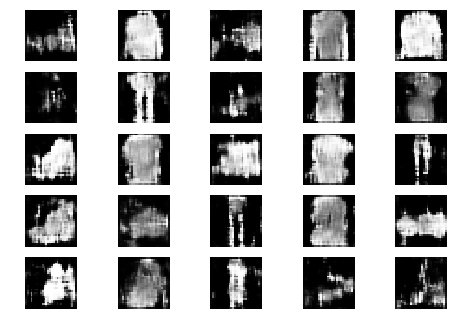

Epoch 0 Batch 801/937 [D loss: 0.696209, acc.: 59.38%] [G loss: 1.360352]
Epoch 0 Batch 802/937 [D loss: 0.669001, acc.: 65.62%] [G loss: 1.477213]
Epoch 0 Batch 803/937 [D loss: 0.421225, acc.: 81.25%] [G loss: 1.325304]
Epoch 0 Batch 804/937 [D loss: 0.633717, acc.: 62.50%] [G loss: 1.295575]
Epoch 0 Batch 805/937 [D loss: 0.624669, acc.: 65.62%] [G loss: 1.397130]
Epoch 0 Batch 806/937 [D loss: 0.472031, acc.: 81.25%] [G loss: 1.653334]
Epoch 0 Batch 807/937 [D loss: 0.769038, acc.: 50.00%] [G loss: 1.532537]
Epoch 0 Batch 808/937 [D loss: 0.593748, acc.: 65.62%] [G loss: 1.622428]


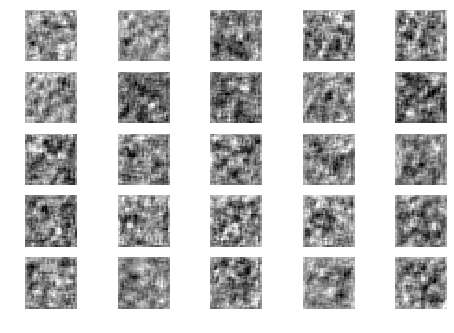

Epoch 0 Batch 809/937 [D loss: 0.474116, acc.: 81.25%] [G loss: 1.521150]
Epoch 0 Batch 810/937 [D loss: 0.514129, acc.: 71.88%] [G loss: 1.616303]
Epoch 0 Batch 811/937 [D loss: 0.781528, acc.: 56.25%] [G loss: 1.217061]
Epoch 0 Batch 812/937 [D loss: 0.591605, acc.: 62.50%] [G loss: 1.307721]
Epoch 0 Batch 813/937 [D loss: 0.678687, acc.: 68.75%] [G loss: 1.333104]
Epoch 0 Batch 814/937 [D loss: 0.482336, acc.: 78.12%] [G loss: 1.176477]
Epoch 0 Batch 815/937 [D loss: 0.581042, acc.: 71.88%] [G loss: 1.255785]
Epoch 0 Batch 816/937 [D loss: 0.778601, acc.: 56.25%] [G loss: 1.309345]


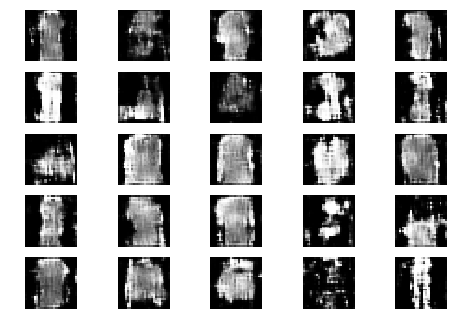

Epoch 0 Batch 817/937 [D loss: 0.789201, acc.: 53.12%] [G loss: 1.416668]
Epoch 0 Batch 818/937 [D loss: 0.775361, acc.: 50.00%] [G loss: 1.086426]
Epoch 0 Batch 819/937 [D loss: 0.470574, acc.: 71.88%] [G loss: 1.386558]
Epoch 0 Batch 820/937 [D loss: 0.641796, acc.: 71.88%] [G loss: 1.306256]
Epoch 0 Batch 821/937 [D loss: 0.575697, acc.: 65.62%] [G loss: 1.244846]
Epoch 0 Batch 822/937 [D loss: 0.471727, acc.: 81.25%] [G loss: 1.312990]
Epoch 0 Batch 823/937 [D loss: 0.310452, acc.: 93.75%] [G loss: 1.499195]
Epoch 0 Batch 824/937 [D loss: 0.534056, acc.: 68.75%] [G loss: 1.209507]
Epoch 0 Batch 825/937 [D loss: 0.462433, acc.: 78.12%] [G loss: 1.080658]
Epoch 0 Batch 826/937 [D loss: 0.398683, acc.: 87.50%] [G loss: 1.220488]
Epoch 0 Batch 827/937 [D loss: 0.600545, acc.: 71.88%] [G loss: 1.462789]
Epoch 0 Batch 828/937 [D loss: 0.521320, acc.: 71.88%] [G loss: 1.397290]
Epoch 0 Batch 829/937 [D loss: 0.627274, acc.: 68.75%] [G loss: 1.588635]
Epoch 0 Batch 830/937 [D loss: 0.34466

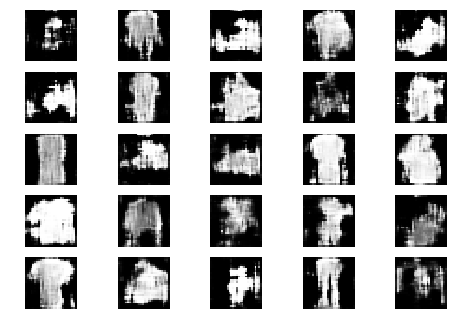

Epoch 0 Batch 901/937 [D loss: 0.475733, acc.: 81.25%] [G loss: 1.535683]
Epoch 0 Batch 902/937 [D loss: 0.471319, acc.: 81.25%] [G loss: 1.582599]
Epoch 0 Batch 903/937 [D loss: 0.530614, acc.: 71.88%] [G loss: 1.515333]
Epoch 0 Batch 904/937 [D loss: 0.405645, acc.: 84.38%] [G loss: 1.288356]
Epoch 0 Batch 905/937 [D loss: 0.507994, acc.: 78.12%] [G loss: 1.412147]
Epoch 0 Batch 906/937 [D loss: 0.564081, acc.: 71.88%] [G loss: 1.890081]
Epoch 0 Batch 907/937 [D loss: 0.573420, acc.: 75.00%] [G loss: 1.432464]
Epoch 0 Batch 908/937 [D loss: 0.612884, acc.: 62.50%] [G loss: 1.580730]
Epoch 0 Batch 909/937 [D loss: 0.454328, acc.: 75.00%] [G loss: 1.520858]


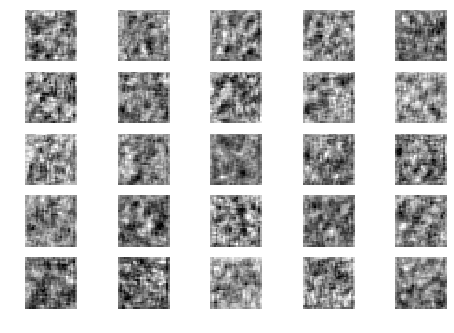

Epoch 0 Batch 910/937 [D loss: 0.377254, acc.: 81.25%] [G loss: 1.924161]
Epoch 0 Batch 911/937 [D loss: 0.411539, acc.: 90.62%] [G loss: 1.588575]
Epoch 0 Batch 912/937 [D loss: 0.516450, acc.: 71.88%] [G loss: 1.175761]
Epoch 0 Batch 913/937 [D loss: 0.706446, acc.: 68.75%] [G loss: 1.258021]
Epoch 0 Batch 914/937 [D loss: 0.779774, acc.: 53.12%] [G loss: 1.366693]
Epoch 0 Batch 915/937 [D loss: 0.393432, acc.: 84.38%] [G loss: 1.545503]
Epoch 0 Batch 916/937 [D loss: 0.589878, acc.: 62.50%] [G loss: 1.035190]
Epoch 0 Batch 917/937 [D loss: 0.482358, acc.: 68.75%] [G loss: 1.461872]
Epoch 0 Batch 918/937 [D loss: 0.442025, acc.: 81.25%] [G loss: 1.270068]


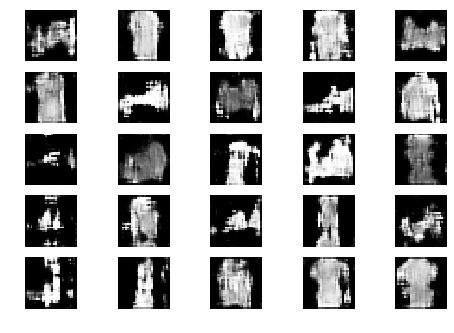

Epoch 0 Batch 919/937 [D loss: 0.646411, acc.: 65.62%] [G loss: 1.313702]
Epoch 0 Batch 920/937 [D loss: 0.487946, acc.: 78.12%] [G loss: 1.643949]
Epoch 0 Batch 921/937 [D loss: 0.568340, acc.: 68.75%] [G loss: 1.701830]
Epoch 0 Batch 922/937 [D loss: 0.547639, acc.: 71.88%] [G loss: 1.742659]
Epoch 0 Batch 923/937 [D loss: 0.450861, acc.: 75.00%] [G loss: 1.439027]
Epoch 0 Batch 924/937 [D loss: 0.459499, acc.: 75.00%] [G loss: 1.519486]
Epoch 0 Batch 925/937 [D loss: 0.612945, acc.: 62.50%] [G loss: 1.112675]
Epoch 0 Batch 926/937 [D loss: 0.653007, acc.: 65.62%] [G loss: 1.413680]
Epoch 0 Batch 927/937 [D loss: 0.601870, acc.: 65.62%] [G loss: 1.082572]
Epoch 0 Batch 928/937 [D loss: 0.761877, acc.: 56.25%] [G loss: 1.820161]
Epoch 0 Batch 929/937 [D loss: 0.558633, acc.: 68.75%] [G loss: 1.353842]
Epoch 0 Batch 930/937 [D loss: 0.449649, acc.: 78.12%] [G loss: 1.459669]
Epoch 0 Batch 931/937 [D loss: 0.788600, acc.: 46.88%] [G loss: 1.226652]
Epoch 0 Batch 932/937 [D loss: 0.58288

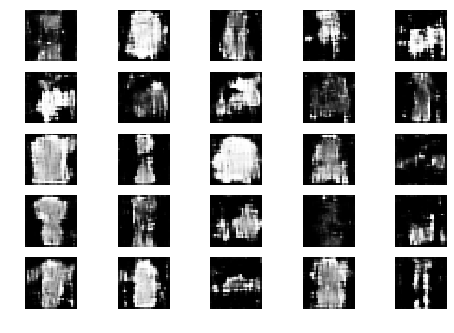

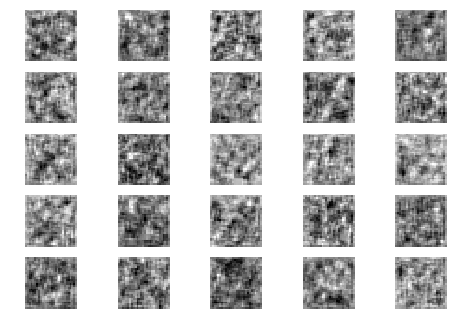

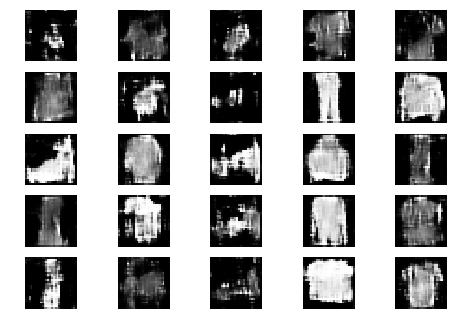

Epoch 1 Batch 1/937 [D loss: 0.955695, acc.: 53.12%] [G loss: 1.367374]
Epoch 1 Batch 2/937 [D loss: 0.444216, acc.: 78.12%] [G loss: 1.474144]
Epoch 1 Batch 3/937 [D loss: 0.538780, acc.: 71.88%] [G loss: 0.930156]
Epoch 1 Batch 4/937 [D loss: 0.590044, acc.: 65.62%] [G loss: 1.610091]
Epoch 1 Batch 5/937 [D loss: 0.475102, acc.: 81.25%] [G loss: 1.287524]
Epoch 1 Batch 6/937 [D loss: 0.611745, acc.: 71.88%] [G loss: 1.150016]
Epoch 1 Batch 7/937 [D loss: 0.548676, acc.: 65.62%] [G loss: 1.509855]
Epoch 1 Batch 8/937 [D loss: 0.613437, acc.: 65.62%] [G loss: 1.797000]
Epoch 1 Batch 9/937 [D loss: 0.449539, acc.: 71.88%] [G loss: 1.642788]
Epoch 1 Batch 10/937 [D loss: 0.497627, acc.: 68.75%] [G loss: 1.697070]
Epoch 1 Batch 11/937 [D loss: 0.625049, acc.: 68.75%] [G loss: 1.100940]
Epoch 1 Batch 12/937 [D loss: 0.757895, acc.: 59.38%] [G loss: 1.197478]
Epoch 1 Batch 13/937 [D loss: 0.791378, acc.: 53.12%] [G loss: 1.300062]
Epoch 1 Batch 14/937 [D loss: 0.546877, acc.: 75.00%] [G los

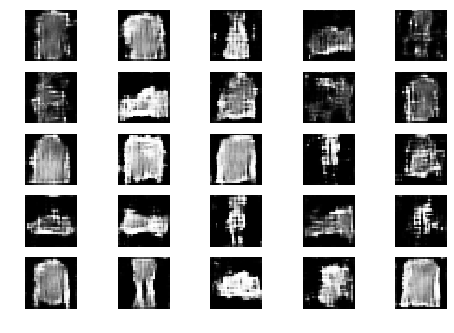

Epoch 1 Batch 101/937 [D loss: 0.792283, acc.: 56.25%] [G loss: 1.632278]


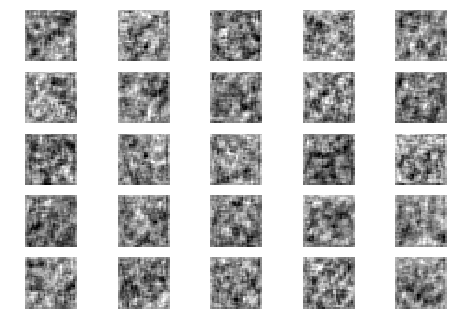

Epoch 1 Batch 102/937 [D loss: 0.714718, acc.: 56.25%] [G loss: 1.223999]


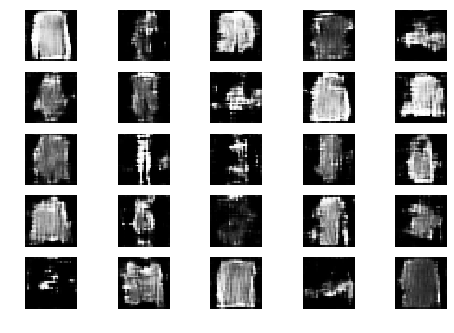

Epoch 1 Batch 103/937 [D loss: 0.528087, acc.: 75.00%] [G loss: 1.326778]
Epoch 1 Batch 104/937 [D loss: 0.681522, acc.: 62.50%] [G loss: 1.387089]
Epoch 1 Batch 105/937 [D loss: 0.625355, acc.: 62.50%] [G loss: 1.186895]
Epoch 1 Batch 106/937 [D loss: 0.625593, acc.: 62.50%] [G loss: 1.610930]
Epoch 1 Batch 107/937 [D loss: 0.488819, acc.: 71.88%] [G loss: 1.421268]
Epoch 1 Batch 108/937 [D loss: 0.858986, acc.: 46.88%] [G loss: 1.587601]
Epoch 1 Batch 109/937 [D loss: 0.681409, acc.: 62.50%] [G loss: 1.440476]
Epoch 1 Batch 110/937 [D loss: 0.465680, acc.: 78.12%] [G loss: 1.703703]
Epoch 1 Batch 111/937 [D loss: 0.527403, acc.: 71.88%] [G loss: 1.606766]
Epoch 1 Batch 112/937 [D loss: 0.505944, acc.: 75.00%] [G loss: 1.609879]
Epoch 1 Batch 113/937 [D loss: 0.696042, acc.: 65.62%] [G loss: 1.286604]
Epoch 1 Batch 114/937 [D loss: 0.528663, acc.: 81.25%] [G loss: 1.317712]
Epoch 1 Batch 115/937 [D loss: 0.664894, acc.: 62.50%] [G loss: 1.220118]
Epoch 1 Batch 116/937 [D loss: 0.67281

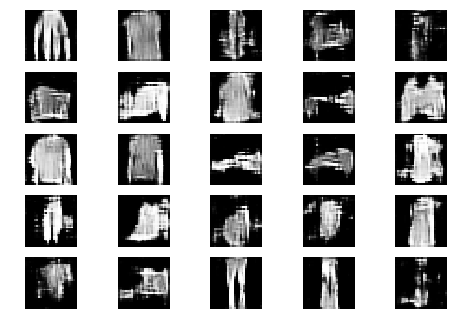

Epoch 1 Batch 201/937 [D loss: 0.539435, acc.: 75.00%] [G loss: 1.485534]
Epoch 1 Batch 202/937 [D loss: 0.552195, acc.: 71.88%] [G loss: 1.160395]


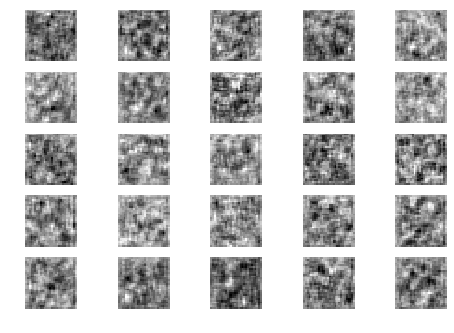

Epoch 1 Batch 203/937 [D loss: 0.712307, acc.: 56.25%] [G loss: 1.023710]
Epoch 1 Batch 204/937 [D loss: 0.542425, acc.: 71.88%] [G loss: 1.345721]


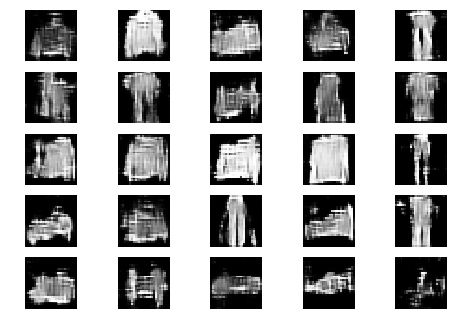

Epoch 1 Batch 205/937 [D loss: 0.599914, acc.: 59.38%] [G loss: 1.268918]
Epoch 1 Batch 206/937 [D loss: 0.468989, acc.: 75.00%] [G loss: 1.474992]
Epoch 1 Batch 207/937 [D loss: 0.466568, acc.: 81.25%] [G loss: 1.219831]
Epoch 1 Batch 208/937 [D loss: 0.690157, acc.: 62.50%] [G loss: 1.479305]
Epoch 1 Batch 209/937 [D loss: 0.497028, acc.: 78.12%] [G loss: 1.265545]
Epoch 1 Batch 210/937 [D loss: 0.558834, acc.: 71.88%] [G loss: 1.143205]
Epoch 1 Batch 211/937 [D loss: 0.615668, acc.: 62.50%] [G loss: 1.052082]
Epoch 1 Batch 212/937 [D loss: 0.531144, acc.: 78.12%] [G loss: 1.242269]
Epoch 1 Batch 213/937 [D loss: 0.525043, acc.: 71.88%] [G loss: 1.274340]
Epoch 1 Batch 214/937 [D loss: 0.547145, acc.: 71.88%] [G loss: 1.329718]
Epoch 1 Batch 215/937 [D loss: 0.526954, acc.: 75.00%] [G loss: 1.450596]
Epoch 1 Batch 216/937 [D loss: 0.435453, acc.: 75.00%] [G loss: 1.652068]
Epoch 1 Batch 217/937 [D loss: 0.701630, acc.: 62.50%] [G loss: 1.148749]
Epoch 1 Batch 218/937 [D loss: 0.53808

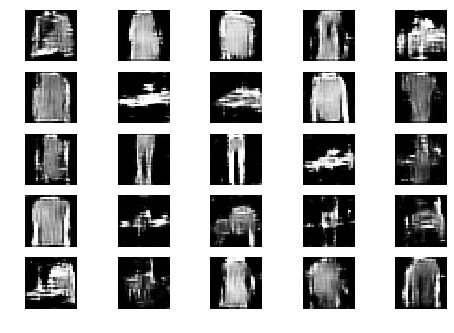

Epoch 1 Batch 301/937 [D loss: 0.571004, acc.: 71.88%] [G loss: 1.230069]
Epoch 1 Batch 302/937 [D loss: 0.536598, acc.: 65.62%] [G loss: 1.035301]
Epoch 1 Batch 303/937 [D loss: 0.530210, acc.: 78.12%] [G loss: 1.144921]


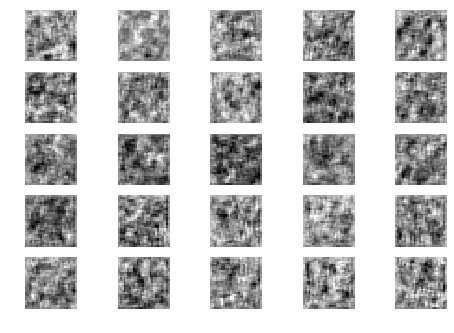

Epoch 1 Batch 304/937 [D loss: 0.705150, acc.: 56.25%] [G loss: 1.182881]
Epoch 1 Batch 305/937 [D loss: 0.535230, acc.: 78.12%] [G loss: 1.489195]
Epoch 1 Batch 306/937 [D loss: 0.461934, acc.: 75.00%] [G loss: 1.144913]


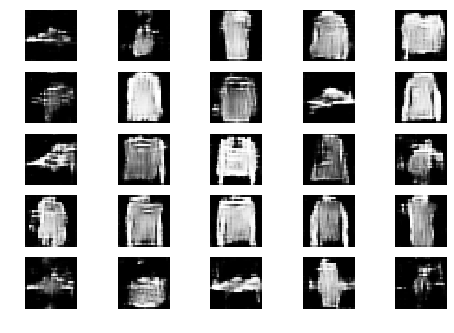

Epoch 1 Batch 307/937 [D loss: 0.415326, acc.: 87.50%] [G loss: 1.360434]
Epoch 1 Batch 308/937 [D loss: 0.752070, acc.: 56.25%] [G loss: 1.068298]
Epoch 1 Batch 309/937 [D loss: 0.786582, acc.: 53.12%] [G loss: 1.159601]
Epoch 1 Batch 310/937 [D loss: 0.721489, acc.: 62.50%] [G loss: 1.282859]
Epoch 1 Batch 311/937 [D loss: 0.586648, acc.: 65.62%] [G loss: 1.386391]
Epoch 1 Batch 312/937 [D loss: 0.549261, acc.: 68.75%] [G loss: 1.324462]
Epoch 1 Batch 313/937 [D loss: 0.550897, acc.: 71.88%] [G loss: 1.960494]
Epoch 1 Batch 314/937 [D loss: 0.542300, acc.: 75.00%] [G loss: 1.693289]
Epoch 1 Batch 315/937 [D loss: 0.737590, acc.: 53.12%] [G loss: 1.234646]
Epoch 1 Batch 316/937 [D loss: 0.629778, acc.: 62.50%] [G loss: 1.376236]
Epoch 1 Batch 317/937 [D loss: 0.370248, acc.: 84.38%] [G loss: 1.509957]
Epoch 1 Batch 318/937 [D loss: 0.666351, acc.: 65.62%] [G loss: 1.124197]
Epoch 1 Batch 319/937 [D loss: 0.490323, acc.: 81.25%] [G loss: 1.213190]
Epoch 1 Batch 320/937 [D loss: 0.52330

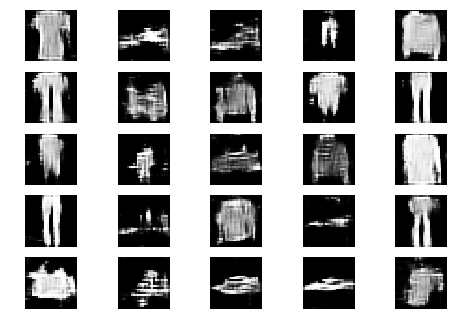

Epoch 1 Batch 401/937 [D loss: 0.606868, acc.: 71.88%] [G loss: 1.302396]
Epoch 1 Batch 402/937 [D loss: 0.831574, acc.: 50.00%] [G loss: 1.092708]
Epoch 1 Batch 403/937 [D loss: 0.604100, acc.: 68.75%] [G loss: 1.365956]
Epoch 1 Batch 404/937 [D loss: 0.631003, acc.: 59.38%] [G loss: 0.966723]


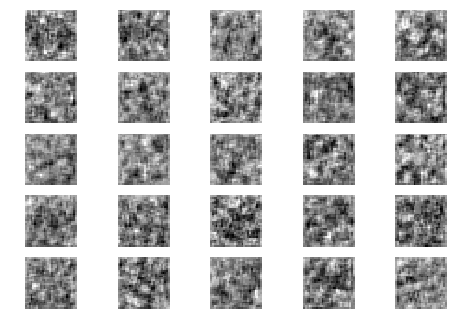

Epoch 1 Batch 405/937 [D loss: 0.490990, acc.: 84.38%] [G loss: 1.045244]
Epoch 1 Batch 406/937 [D loss: 0.732283, acc.: 46.88%] [G loss: 0.856679]
Epoch 1 Batch 407/937 [D loss: 0.607460, acc.: 59.38%] [G loss: 0.890431]
Epoch 1 Batch 408/937 [D loss: 0.798297, acc.: 53.12%] [G loss: 1.081795]


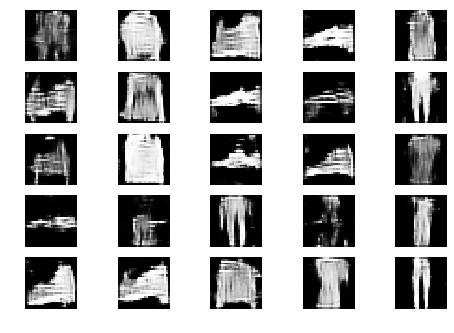

Epoch 1 Batch 409/937 [D loss: 0.665536, acc.: 65.62%] [G loss: 1.089232]
Epoch 1 Batch 410/937 [D loss: 0.482130, acc.: 84.38%] [G loss: 1.301675]
Epoch 1 Batch 411/937 [D loss: 0.479658, acc.: 84.38%] [G loss: 1.255385]
Epoch 1 Batch 412/937 [D loss: 0.766336, acc.: 53.12%] [G loss: 1.345382]
Epoch 1 Batch 413/937 [D loss: 0.692723, acc.: 71.88%] [G loss: 1.279277]
Epoch 1 Batch 414/937 [D loss: 0.681254, acc.: 71.88%] [G loss: 1.158255]
Epoch 1 Batch 415/937 [D loss: 0.844325, acc.: 56.25%] [G loss: 1.138720]
Epoch 1 Batch 416/937 [D loss: 0.683390, acc.: 75.00%] [G loss: 0.944183]
Epoch 1 Batch 417/937 [D loss: 0.675033, acc.: 65.62%] [G loss: 1.623792]
Epoch 1 Batch 418/937 [D loss: 0.622485, acc.: 65.62%] [G loss: 1.089188]
Epoch 1 Batch 419/937 [D loss: 0.714245, acc.: 65.62%] [G loss: 1.112852]
Epoch 1 Batch 420/937 [D loss: 0.753849, acc.: 53.12%] [G loss: 1.184511]
Epoch 1 Batch 421/937 [D loss: 0.758789, acc.: 65.62%] [G loss: 1.048564]
Epoch 1 Batch 422/937 [D loss: 0.76583

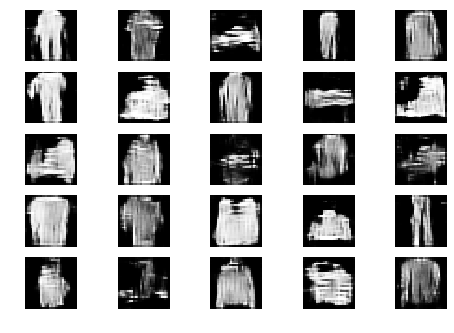

Epoch 1 Batch 501/937 [D loss: 0.651813, acc.: 68.75%] [G loss: 1.251708]
Epoch 1 Batch 502/937 [D loss: 0.818045, acc.: 46.88%] [G loss: 1.274844]
Epoch 1 Batch 503/937 [D loss: 0.636354, acc.: 75.00%] [G loss: 1.581336]
Epoch 1 Batch 504/937 [D loss: 0.609553, acc.: 62.50%] [G loss: 1.333334]
Epoch 1 Batch 505/937 [D loss: 0.499084, acc.: 75.00%] [G loss: 1.432223]


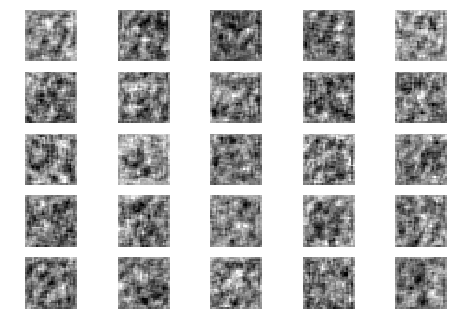

Epoch 1 Batch 506/937 [D loss: 0.711841, acc.: 59.38%] [G loss: 1.570380]
Epoch 1 Batch 507/937 [D loss: 0.712879, acc.: 50.00%] [G loss: 1.026525]
Epoch 1 Batch 508/937 [D loss: 0.684871, acc.: 62.50%] [G loss: 1.278245]
Epoch 1 Batch 509/937 [D loss: 0.549234, acc.: 65.62%] [G loss: 1.167896]
Epoch 1 Batch 510/937 [D loss: 0.705531, acc.: 65.62%] [G loss: 1.244714]


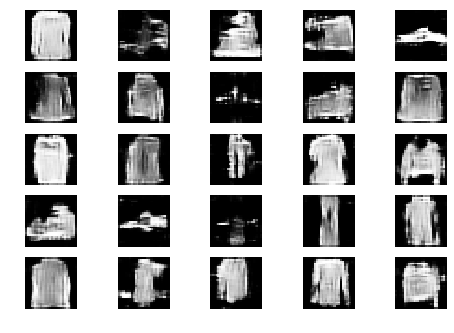

Epoch 1 Batch 511/937 [D loss: 0.914795, acc.: 40.62%] [G loss: 1.263778]
Epoch 1 Batch 512/937 [D loss: 0.523626, acc.: 75.00%] [G loss: 1.284850]
Epoch 1 Batch 513/937 [D loss: 0.685909, acc.: 65.62%] [G loss: 1.114118]
Epoch 1 Batch 514/937 [D loss: 0.844145, acc.: 50.00%] [G loss: 1.155571]
Epoch 1 Batch 515/937 [D loss: 0.832289, acc.: 50.00%] [G loss: 0.948119]
Epoch 1 Batch 516/937 [D loss: 0.571632, acc.: 71.88%] [G loss: 0.788265]
Epoch 1 Batch 517/937 [D loss: 0.720768, acc.: 59.38%] [G loss: 0.864139]
Epoch 1 Batch 518/937 [D loss: 0.551658, acc.: 75.00%] [G loss: 1.135332]
Epoch 1 Batch 519/937 [D loss: 0.511668, acc.: 75.00%] [G loss: 1.191796]
Epoch 1 Batch 520/937 [D loss: 0.470804, acc.: 75.00%] [G loss: 1.084759]
Epoch 1 Batch 521/937 [D loss: 0.470164, acc.: 87.50%] [G loss: 1.150378]
Epoch 1 Batch 522/937 [D loss: 0.684562, acc.: 65.62%] [G loss: 1.098218]
Epoch 1 Batch 523/937 [D loss: 0.694330, acc.: 56.25%] [G loss: 1.140818]
Epoch 1 Batch 524/937 [D loss: 0.62351

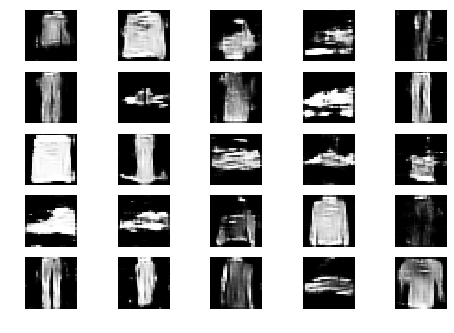

Epoch 1 Batch 601/937 [D loss: 0.610342, acc.: 68.75%] [G loss: 1.413944]
Epoch 1 Batch 602/937 [D loss: 0.736309, acc.: 59.38%] [G loss: 1.255814]
Epoch 1 Batch 603/937 [D loss: 0.628371, acc.: 65.62%] [G loss: 0.979008]
Epoch 1 Batch 604/937 [D loss: 0.747118, acc.: 46.88%] [G loss: 1.271995]
Epoch 1 Batch 605/937 [D loss: 0.691191, acc.: 53.12%] [G loss: 1.192831]
Epoch 1 Batch 606/937 [D loss: 0.579858, acc.: 68.75%] [G loss: 1.065781]


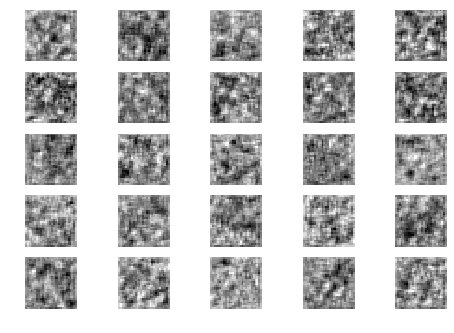

Epoch 1 Batch 607/937 [D loss: 0.850583, acc.: 43.75%] [G loss: 0.889785]
Epoch 1 Batch 608/937 [D loss: 0.521435, acc.: 78.12%] [G loss: 1.037954]
Epoch 1 Batch 609/937 [D loss: 0.917286, acc.: 50.00%] [G loss: 1.367774]
Epoch 1 Batch 610/937 [D loss: 0.517502, acc.: 78.12%] [G loss: 1.231668]
Epoch 1 Batch 611/937 [D loss: 0.824543, acc.: 56.25%] [G loss: 1.431229]
Epoch 1 Batch 612/937 [D loss: 0.504161, acc.: 68.75%] [G loss: 1.427073]


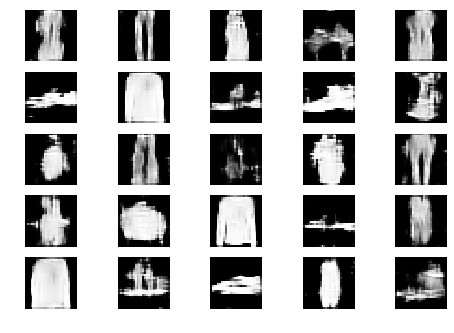

Epoch 1 Batch 613/937 [D loss: 0.618520, acc.: 68.75%] [G loss: 1.232560]
Epoch 1 Batch 614/937 [D loss: 0.644820, acc.: 65.62%] [G loss: 1.570365]
Epoch 1 Batch 615/937 [D loss: 0.508354, acc.: 68.75%] [G loss: 1.464773]
Epoch 1 Batch 616/937 [D loss: 0.688378, acc.: 56.25%] [G loss: 1.232540]
Epoch 1 Batch 617/937 [D loss: 0.485041, acc.: 71.88%] [G loss: 1.239027]
Epoch 1 Batch 618/937 [D loss: 0.635681, acc.: 65.62%] [G loss: 1.237009]
Epoch 1 Batch 619/937 [D loss: 0.680411, acc.: 62.50%] [G loss: 1.345222]
Epoch 1 Batch 620/937 [D loss: 0.821151, acc.: 53.12%] [G loss: 1.360445]
Epoch 1 Batch 621/937 [D loss: 0.622208, acc.: 75.00%] [G loss: 1.086744]
Epoch 1 Batch 622/937 [D loss: 0.655711, acc.: 59.38%] [G loss: 1.401350]
Epoch 1 Batch 623/937 [D loss: 0.539433, acc.: 71.88%] [G loss: 1.162555]
Epoch 1 Batch 624/937 [D loss: 0.481684, acc.: 71.88%] [G loss: 1.178461]
Epoch 1 Batch 625/937 [D loss: 0.758631, acc.: 53.12%] [G loss: 1.049719]
Epoch 1 Batch 626/937 [D loss: 0.60141

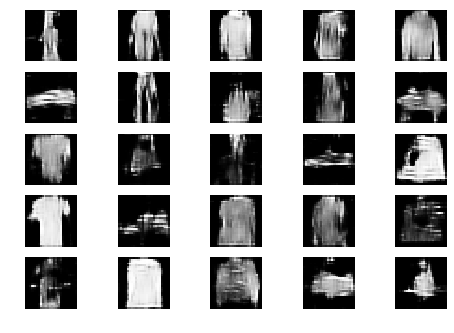

Epoch 1 Batch 701/937 [D loss: 0.536465, acc.: 75.00%] [G loss: 1.235528]
Epoch 1 Batch 702/937 [D loss: 0.784515, acc.: 56.25%] [G loss: 1.101481]
Epoch 1 Batch 703/937 [D loss: 0.533310, acc.: 75.00%] [G loss: 1.263730]
Epoch 1 Batch 704/937 [D loss: 0.539650, acc.: 71.88%] [G loss: 1.293758]
Epoch 1 Batch 705/937 [D loss: 0.577260, acc.: 68.75%] [G loss: 1.558310]
Epoch 1 Batch 706/937 [D loss: 0.736853, acc.: 56.25%] [G loss: 1.322675]
Epoch 1 Batch 707/937 [D loss: 0.710495, acc.: 65.62%] [G loss: 1.168284]


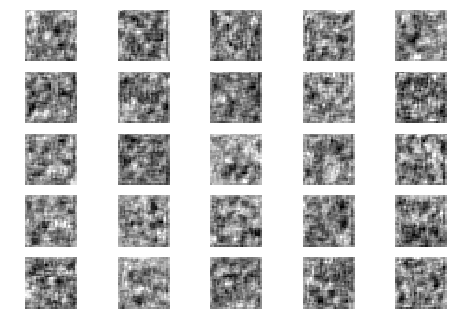

Epoch 1 Batch 708/937 [D loss: 0.516176, acc.: 65.62%] [G loss: 1.264153]
Epoch 1 Batch 709/937 [D loss: 0.761639, acc.: 59.38%] [G loss: 1.090843]
Epoch 1 Batch 710/937 [D loss: 0.556512, acc.: 75.00%] [G loss: 1.083476]
Epoch 1 Batch 711/937 [D loss: 0.544253, acc.: 71.88%] [G loss: 0.817591]
Epoch 1 Batch 712/937 [D loss: 0.430042, acc.: 84.38%] [G loss: 1.156659]
Epoch 1 Batch 713/937 [D loss: 0.698360, acc.: 59.38%] [G loss: 1.210623]
Epoch 1 Batch 714/937 [D loss: 0.604165, acc.: 65.62%] [G loss: 1.044756]


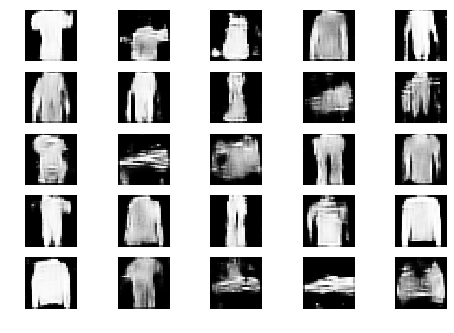

Epoch 1 Batch 715/937 [D loss: 0.780040, acc.: 59.38%] [G loss: 1.375554]
Epoch 1 Batch 716/937 [D loss: 0.584363, acc.: 71.88%] [G loss: 1.298915]
Epoch 1 Batch 717/937 [D loss: 0.725611, acc.: 59.38%] [G loss: 1.393996]
Epoch 1 Batch 718/937 [D loss: 0.807932, acc.: 56.25%] [G loss: 1.120361]
Epoch 1 Batch 719/937 [D loss: 0.593746, acc.: 59.38%] [G loss: 1.182528]
Epoch 1 Batch 720/937 [D loss: 0.712076, acc.: 53.12%] [G loss: 1.001453]
Epoch 1 Batch 721/937 [D loss: 0.675232, acc.: 65.62%] [G loss: 1.246757]
Epoch 1 Batch 722/937 [D loss: 0.593661, acc.: 78.12%] [G loss: 1.458488]
Epoch 1 Batch 723/937 [D loss: 0.721504, acc.: 56.25%] [G loss: 1.202820]
Epoch 1 Batch 724/937 [D loss: 0.697136, acc.: 53.12%] [G loss: 1.027336]
Epoch 1 Batch 725/937 [D loss: 0.664096, acc.: 65.62%] [G loss: 1.192082]
Epoch 1 Batch 726/937 [D loss: 0.666080, acc.: 59.38%] [G loss: 1.210221]
Epoch 1 Batch 727/937 [D loss: 0.645778, acc.: 65.62%] [G loss: 1.001723]
Epoch 1 Batch 728/937 [D loss: 0.55672

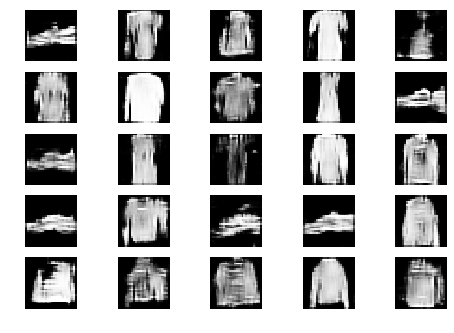

Epoch 1 Batch 801/937 [D loss: 0.682790, acc.: 59.38%] [G loss: 1.192124]
Epoch 1 Batch 802/937 [D loss: 0.752906, acc.: 46.88%] [G loss: 1.131226]
Epoch 1 Batch 803/937 [D loss: 0.618398, acc.: 65.62%] [G loss: 0.894298]
Epoch 1 Batch 804/937 [D loss: 0.615543, acc.: 59.38%] [G loss: 1.197849]
Epoch 1 Batch 805/937 [D loss: 0.793522, acc.: 53.12%] [G loss: 0.916664]
Epoch 1 Batch 806/937 [D loss: 0.693192, acc.: 65.62%] [G loss: 0.732632]
Epoch 1 Batch 807/937 [D loss: 0.869859, acc.: 50.00%] [G loss: 1.128827]
Epoch 1 Batch 808/937 [D loss: 0.498930, acc.: 75.00%] [G loss: 1.389454]


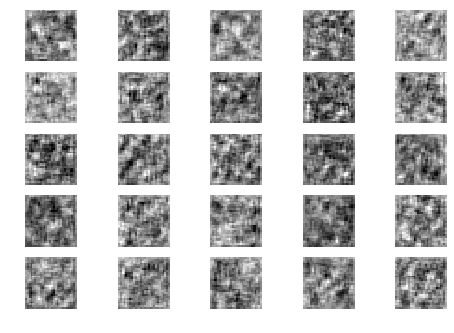

Epoch 1 Batch 809/937 [D loss: 0.748734, acc.: 65.62%] [G loss: 1.074110]
Epoch 1 Batch 810/937 [D loss: 0.693545, acc.: 56.25%] [G loss: 0.929695]
Epoch 1 Batch 811/937 [D loss: 0.508932, acc.: 75.00%] [G loss: 1.120023]
Epoch 1 Batch 812/937 [D loss: 0.682696, acc.: 65.62%] [G loss: 0.846696]
Epoch 1 Batch 813/937 [D loss: 0.582193, acc.: 62.50%] [G loss: 0.751697]
Epoch 1 Batch 814/937 [D loss: 0.544148, acc.: 78.12%] [G loss: 0.996627]
Epoch 1 Batch 815/937 [D loss: 0.442886, acc.: 87.50%] [G loss: 1.070729]
Epoch 1 Batch 816/937 [D loss: 0.800448, acc.: 50.00%] [G loss: 1.137764]


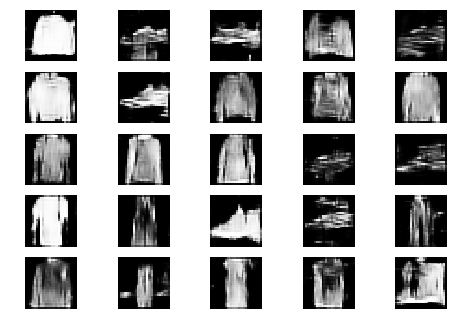

Epoch 1 Batch 817/937 [D loss: 0.547683, acc.: 68.75%] [G loss: 0.999037]
Epoch 1 Batch 818/937 [D loss: 0.779404, acc.: 50.00%] [G loss: 1.103208]
Epoch 1 Batch 819/937 [D loss: 0.685020, acc.: 62.50%] [G loss: 1.102645]
Epoch 1 Batch 820/937 [D loss: 0.699697, acc.: 56.25%] [G loss: 1.183667]
Epoch 1 Batch 821/937 [D loss: 0.616081, acc.: 71.88%] [G loss: 1.209390]
Epoch 1 Batch 822/937 [D loss: 0.949951, acc.: 43.75%] [G loss: 1.401962]
Epoch 1 Batch 823/937 [D loss: 0.511687, acc.: 75.00%] [G loss: 1.121415]
Epoch 1 Batch 824/937 [D loss: 0.591550, acc.: 68.75%] [G loss: 0.986287]
Epoch 1 Batch 825/937 [D loss: 0.588885, acc.: 59.38%] [G loss: 1.247616]
Epoch 1 Batch 826/937 [D loss: 0.563813, acc.: 68.75%] [G loss: 1.190521]
Epoch 1 Batch 827/937 [D loss: 0.900275, acc.: 50.00%] [G loss: 1.216568]
Epoch 1 Batch 828/937 [D loss: 0.691712, acc.: 53.12%] [G loss: 1.367020]
Epoch 1 Batch 829/937 [D loss: 0.689764, acc.: 65.62%] [G loss: 1.077327]
Epoch 1 Batch 830/937 [D loss: 0.54273

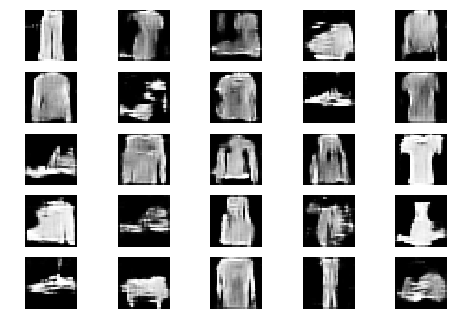

Epoch 1 Batch 901/937 [D loss: 0.741116, acc.: 59.38%] [G loss: 1.240895]
Epoch 1 Batch 902/937 [D loss: 0.660316, acc.: 59.38%] [G loss: 0.987970]
Epoch 1 Batch 903/937 [D loss: 0.473192, acc.: 78.12%] [G loss: 0.976125]
Epoch 1 Batch 904/937 [D loss: 0.699460, acc.: 65.62%] [G loss: 1.138991]
Epoch 1 Batch 905/937 [D loss: 0.601410, acc.: 62.50%] [G loss: 1.090032]
Epoch 1 Batch 906/937 [D loss: 0.758263, acc.: 40.62%] [G loss: 1.032932]
Epoch 1 Batch 907/937 [D loss: 0.768665, acc.: 56.25%] [G loss: 1.071102]
Epoch 1 Batch 908/937 [D loss: 0.551115, acc.: 71.88%] [G loss: 1.281542]
Epoch 1 Batch 909/937 [D loss: 0.741379, acc.: 65.62%] [G loss: 1.147148]


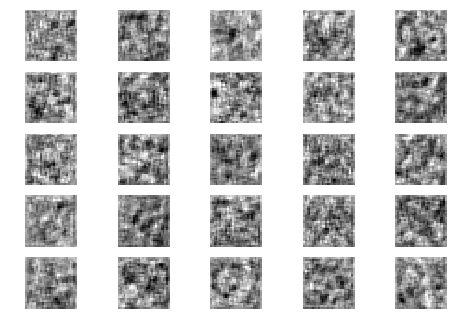

Epoch 1 Batch 910/937 [D loss: 0.615788, acc.: 68.75%] [G loss: 1.239424]
Epoch 1 Batch 911/937 [D loss: 0.629996, acc.: 50.00%] [G loss: 1.061975]
Epoch 1 Batch 912/937 [D loss: 0.491091, acc.: 81.25%] [G loss: 1.101852]
Epoch 1 Batch 913/937 [D loss: 0.834228, acc.: 50.00%] [G loss: 1.322259]
Epoch 1 Batch 914/937 [D loss: 0.643493, acc.: 56.25%] [G loss: 1.319837]
Epoch 1 Batch 915/937 [D loss: 0.593443, acc.: 71.88%] [G loss: 1.192166]
Epoch 1 Batch 916/937 [D loss: 0.572159, acc.: 78.12%] [G loss: 1.250327]
Epoch 1 Batch 917/937 [D loss: 0.666472, acc.: 56.25%] [G loss: 1.039540]
Epoch 1 Batch 918/937 [D loss: 0.579721, acc.: 68.75%] [G loss: 1.161766]


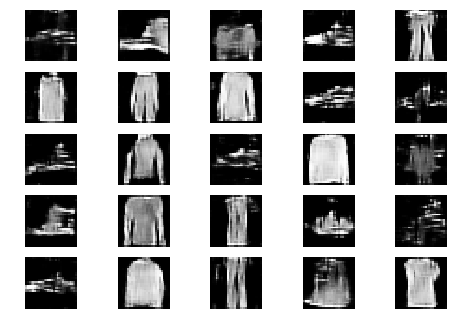

Epoch 1 Batch 919/937 [D loss: 0.601888, acc.: 59.38%] [G loss: 1.024472]
Epoch 1 Batch 920/937 [D loss: 0.593361, acc.: 75.00%] [G loss: 1.324506]
Epoch 1 Batch 921/937 [D loss: 0.695979, acc.: 46.88%] [G loss: 1.202850]
Epoch 1 Batch 922/937 [D loss: 0.665777, acc.: 53.12%] [G loss: 1.107692]
Epoch 1 Batch 923/937 [D loss: 0.561879, acc.: 78.12%] [G loss: 1.211594]
Epoch 1 Batch 924/937 [D loss: 0.772685, acc.: 56.25%] [G loss: 1.337166]
Epoch 1 Batch 925/937 [D loss: 0.601704, acc.: 65.62%] [G loss: 1.261065]
Epoch 1 Batch 926/937 [D loss: 0.537703, acc.: 68.75%] [G loss: 1.147007]
Epoch 1 Batch 927/937 [D loss: 0.655219, acc.: 59.38%] [G loss: 0.892784]
Epoch 1 Batch 928/937 [D loss: 0.622056, acc.: 65.62%] [G loss: 0.959317]
Epoch 1 Batch 929/937 [D loss: 0.750876, acc.: 50.00%] [G loss: 1.296448]
Epoch 1 Batch 930/937 [D loss: 0.711417, acc.: 56.25%] [G loss: 1.042907]
Epoch 1 Batch 931/937 [D loss: 0.699625, acc.: 56.25%] [G loss: 1.346698]
Epoch 1 Batch 932/937 [D loss: 0.81378

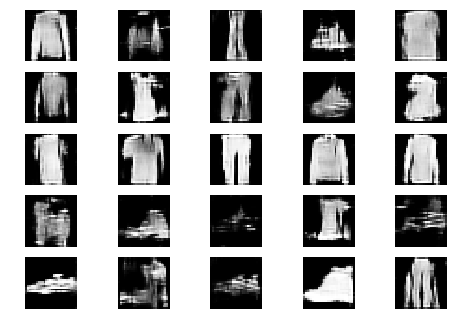

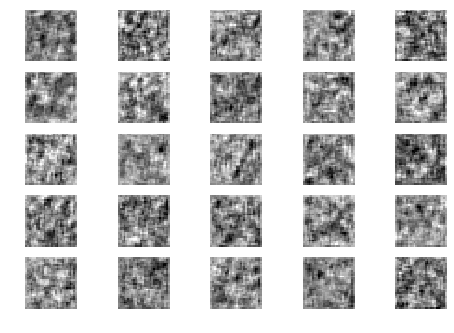

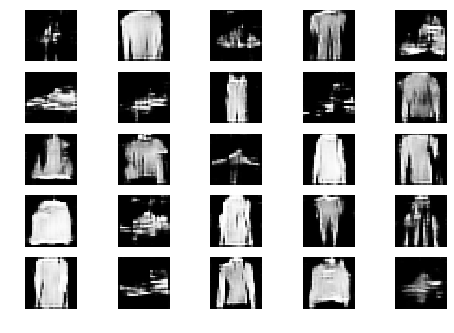

Epoch 2 Batch 1/937 [D loss: 0.691231, acc.: 56.25%] [G loss: 1.204338]
Epoch 2 Batch 2/937 [D loss: 0.497919, acc.: 71.88%] [G loss: 1.262590]
Epoch 2 Batch 3/937 [D loss: 0.723629, acc.: 62.50%] [G loss: 1.253258]
Epoch 2 Batch 4/937 [D loss: 0.710883, acc.: 53.12%] [G loss: 0.859815]
Epoch 2 Batch 5/937 [D loss: 0.656758, acc.: 62.50%] [G loss: 0.932775]
Epoch 2 Batch 6/937 [D loss: 0.871383, acc.: 43.75%] [G loss: 1.002992]
Epoch 2 Batch 7/937 [D loss: 0.578663, acc.: 68.75%] [G loss: 1.009031]
Epoch 2 Batch 8/937 [D loss: 0.512670, acc.: 71.88%] [G loss: 1.188694]
Epoch 2 Batch 9/937 [D loss: 0.614865, acc.: 62.50%] [G loss: 1.156768]
Epoch 2 Batch 10/937 [D loss: 0.496688, acc.: 78.12%] [G loss: 1.176432]
Epoch 2 Batch 11/937 [D loss: 0.677571, acc.: 53.12%] [G loss: 0.869256]
Epoch 2 Batch 12/937 [D loss: 0.639700, acc.: 65.62%] [G loss: 1.171020]
Epoch 2 Batch 13/937 [D loss: 0.716481, acc.: 50.00%] [G loss: 1.001338]
Epoch 2 Batch 14/937 [D loss: 0.632173, acc.: 68.75%] [G los

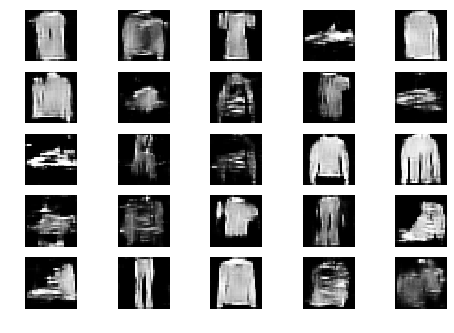

Epoch 2 Batch 101/937 [D loss: 0.762384, acc.: 59.38%] [G loss: 1.280359]


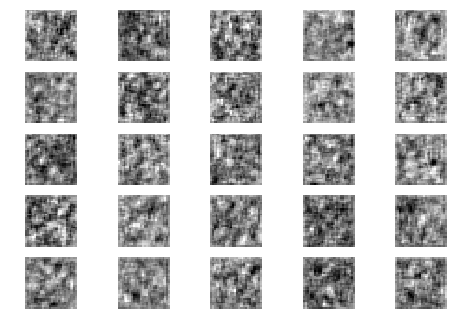

Epoch 2 Batch 102/937 [D loss: 0.748616, acc.: 59.38%] [G loss: 1.337467]


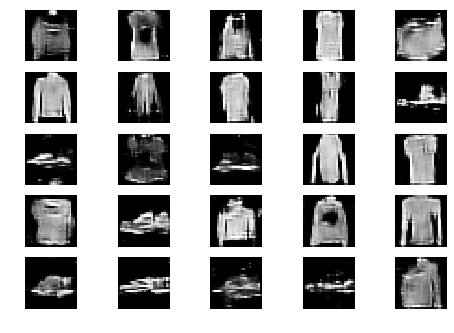

Epoch 2 Batch 103/937 [D loss: 0.773144, acc.: 50.00%] [G loss: 1.151844]
Epoch 2 Batch 104/937 [D loss: 0.634678, acc.: 62.50%] [G loss: 1.365160]
Epoch 2 Batch 105/937 [D loss: 0.514020, acc.: 75.00%] [G loss: 1.211649]
Epoch 2 Batch 106/937 [D loss: 0.550106, acc.: 68.75%] [G loss: 1.193272]
Epoch 2 Batch 107/937 [D loss: 0.704043, acc.: 59.38%] [G loss: 1.027220]
Epoch 2 Batch 108/937 [D loss: 0.682150, acc.: 59.38%] [G loss: 1.150963]
Epoch 2 Batch 109/937 [D loss: 0.614596, acc.: 68.75%] [G loss: 1.191906]
Epoch 2 Batch 110/937 [D loss: 0.488359, acc.: 62.50%] [G loss: 1.195338]
Epoch 2 Batch 111/937 [D loss: 0.668116, acc.: 59.38%] [G loss: 1.013770]
Epoch 2 Batch 112/937 [D loss: 0.606315, acc.: 68.75%] [G loss: 1.004985]
Epoch 2 Batch 113/937 [D loss: 0.654216, acc.: 68.75%] [G loss: 1.236742]
Epoch 2 Batch 114/937 [D loss: 0.842802, acc.: 46.88%] [G loss: 1.160064]
Epoch 2 Batch 115/937 [D loss: 0.632899, acc.: 65.62%] [G loss: 1.034597]
Epoch 2 Batch 116/937 [D loss: 0.67120

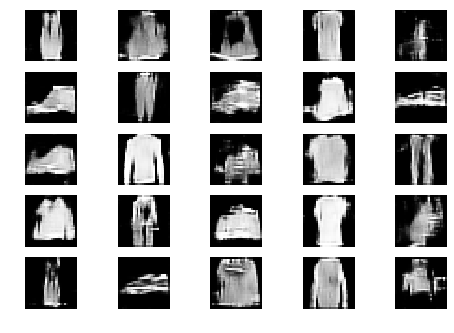

Epoch 2 Batch 201/937 [D loss: 0.573841, acc.: 75.00%] [G loss: 0.952126]
Epoch 2 Batch 202/937 [D loss: 0.712606, acc.: 62.50%] [G loss: 1.179617]


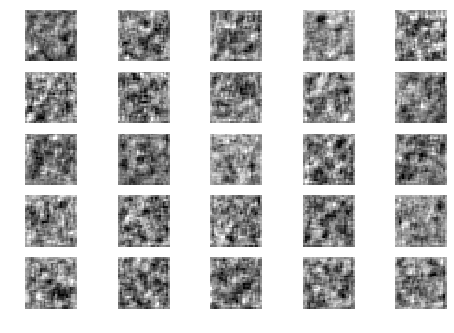

Epoch 2 Batch 203/937 [D loss: 0.671480, acc.: 71.88%] [G loss: 0.928624]
Epoch 2 Batch 204/937 [D loss: 0.751143, acc.: 46.88%] [G loss: 0.974278]


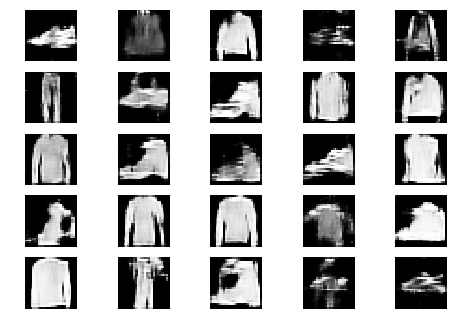

Epoch 2 Batch 205/937 [D loss: 0.506294, acc.: 75.00%] [G loss: 1.305371]
Epoch 2 Batch 206/937 [D loss: 0.621828, acc.: 62.50%] [G loss: 1.004043]
Epoch 2 Batch 207/937 [D loss: 0.696661, acc.: 53.12%] [G loss: 1.182737]
Epoch 2 Batch 208/937 [D loss: 0.604047, acc.: 65.62%] [G loss: 1.264361]
Epoch 2 Batch 209/937 [D loss: 0.723874, acc.: 65.62%] [G loss: 1.149992]
Epoch 2 Batch 210/937 [D loss: 0.606707, acc.: 75.00%] [G loss: 1.022089]
Epoch 2 Batch 211/937 [D loss: 0.742595, acc.: 53.12%] [G loss: 0.903929]
Epoch 2 Batch 212/937 [D loss: 0.654756, acc.: 56.25%] [G loss: 0.899528]
Epoch 2 Batch 213/937 [D loss: 0.578867, acc.: 65.62%] [G loss: 1.311108]
Epoch 2 Batch 214/937 [D loss: 0.632642, acc.: 68.75%] [G loss: 1.346553]
Epoch 2 Batch 215/937 [D loss: 0.650793, acc.: 75.00%] [G loss: 1.063319]
Epoch 2 Batch 216/937 [D loss: 0.533741, acc.: 71.88%] [G loss: 1.237713]
Epoch 2 Batch 217/937 [D loss: 0.643600, acc.: 62.50%] [G loss: 0.952998]
Epoch 2 Batch 218/937 [D loss: 0.53435

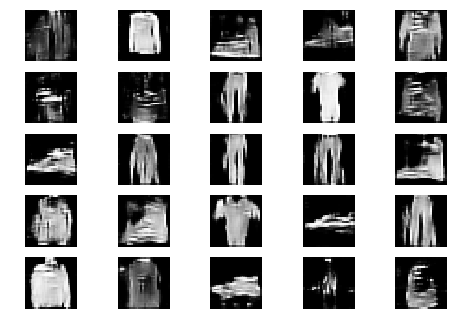

Epoch 2 Batch 301/937 [D loss: 0.681796, acc.: 56.25%] [G loss: 1.245211]
Epoch 2 Batch 302/937 [D loss: 0.892695, acc.: 43.75%] [G loss: 1.098256]
Epoch 2 Batch 303/937 [D loss: 0.651576, acc.: 65.62%] [G loss: 1.195130]


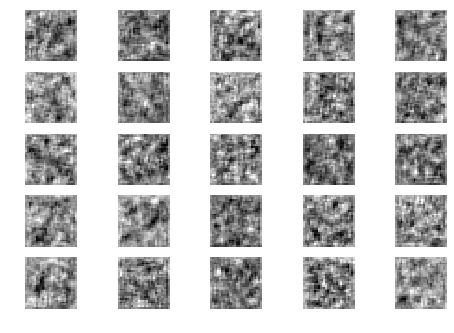

Epoch 2 Batch 304/937 [D loss: 0.620609, acc.: 59.38%] [G loss: 1.214406]
Epoch 2 Batch 305/937 [D loss: 0.452730, acc.: 75.00%] [G loss: 1.097688]
Epoch 2 Batch 306/937 [D loss: 0.496424, acc.: 75.00%] [G loss: 1.364746]


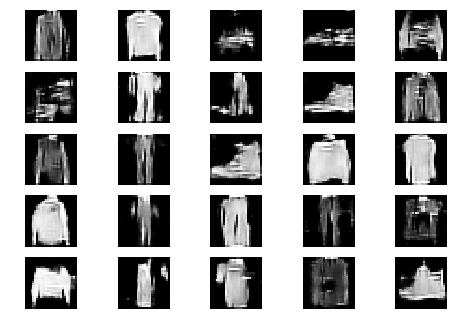

Epoch 2 Batch 307/937 [D loss: 0.884041, acc.: 56.25%] [G loss: 1.127404]
Epoch 2 Batch 308/937 [D loss: 0.698475, acc.: 56.25%] [G loss: 1.112051]
Epoch 2 Batch 309/937 [D loss: 0.544854, acc.: 78.12%] [G loss: 1.230841]
Epoch 2 Batch 310/937 [D loss: 0.629952, acc.: 68.75%] [G loss: 1.014014]
Epoch 2 Batch 311/937 [D loss: 0.594108, acc.: 62.50%] [G loss: 1.199430]
Epoch 2 Batch 312/937 [D loss: 0.664163, acc.: 56.25%] [G loss: 1.231155]
Epoch 2 Batch 313/937 [D loss: 0.758997, acc.: 46.88%] [G loss: 0.992995]
Epoch 2 Batch 314/937 [D loss: 0.679977, acc.: 62.50%] [G loss: 1.137441]
Epoch 2 Batch 315/937 [D loss: 0.762853, acc.: 53.12%] [G loss: 1.341488]
Epoch 2 Batch 316/937 [D loss: 0.685729, acc.: 53.12%] [G loss: 1.082936]
Epoch 2 Batch 317/937 [D loss: 0.587544, acc.: 68.75%] [G loss: 1.149968]
Epoch 2 Batch 318/937 [D loss: 0.588008, acc.: 68.75%] [G loss: 1.326268]
Epoch 2 Batch 319/937 [D loss: 0.600372, acc.: 68.75%] [G loss: 1.028033]
Epoch 2 Batch 320/937 [D loss: 0.62110

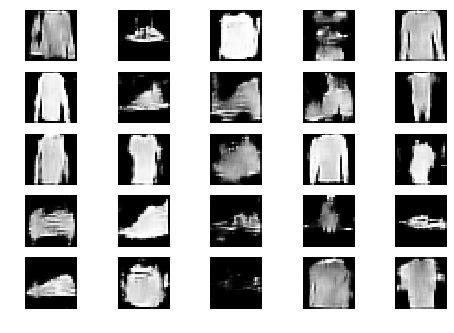

Epoch 2 Batch 401/937 [D loss: 0.692997, acc.: 53.12%] [G loss: 1.103553]
Epoch 2 Batch 402/937 [D loss: 0.743167, acc.: 59.38%] [G loss: 1.161248]
Epoch 2 Batch 403/937 [D loss: 0.633448, acc.: 71.88%] [G loss: 1.019431]
Epoch 2 Batch 404/937 [D loss: 0.654359, acc.: 59.38%] [G loss: 1.058115]


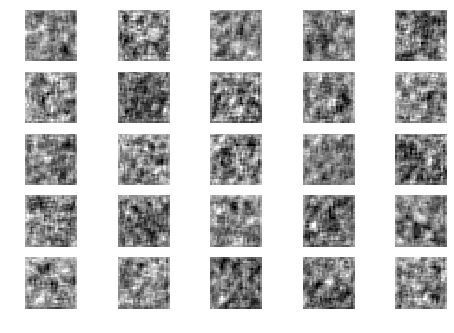

Epoch 2 Batch 405/937 [D loss: 0.758939, acc.: 62.50%] [G loss: 0.957903]
Epoch 2 Batch 406/937 [D loss: 0.702215, acc.: 59.38%] [G loss: 0.822603]
Epoch 2 Batch 407/937 [D loss: 0.606218, acc.: 65.62%] [G loss: 0.929265]
Epoch 2 Batch 408/937 [D loss: 0.532430, acc.: 71.88%] [G loss: 0.887110]


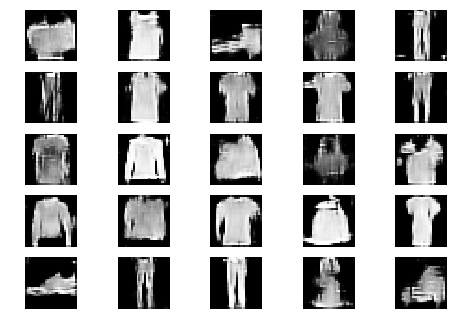

Epoch 2 Batch 409/937 [D loss: 0.833065, acc.: 46.88%] [G loss: 1.063284]
Epoch 2 Batch 410/937 [D loss: 0.673022, acc.: 59.38%] [G loss: 1.035672]
Epoch 2 Batch 411/937 [D loss: 0.627364, acc.: 68.75%] [G loss: 1.001709]
Epoch 2 Batch 412/937 [D loss: 0.683035, acc.: 59.38%] [G loss: 1.078734]
Epoch 2 Batch 413/937 [D loss: 0.739657, acc.: 46.88%] [G loss: 0.982357]
Epoch 2 Batch 414/937 [D loss: 0.718435, acc.: 59.38%] [G loss: 1.163503]
Epoch 2 Batch 415/937 [D loss: 0.575077, acc.: 65.62%] [G loss: 1.062017]
Epoch 2 Batch 416/937 [D loss: 0.673432, acc.: 62.50%] [G loss: 1.012014]
Epoch 2 Batch 417/937 [D loss: 0.619110, acc.: 62.50%] [G loss: 1.093241]
Epoch 2 Batch 418/937 [D loss: 0.723249, acc.: 56.25%] [G loss: 1.361504]
Epoch 2 Batch 419/937 [D loss: 0.551018, acc.: 68.75%] [G loss: 1.100414]
Epoch 2 Batch 420/937 [D loss: 0.621012, acc.: 59.38%] [G loss: 0.890795]
Epoch 2 Batch 421/937 [D loss: 0.618862, acc.: 62.50%] [G loss: 0.934785]
Epoch 2 Batch 422/937 [D loss: 0.65975

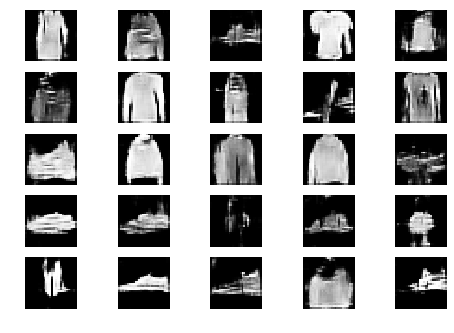

Epoch 2 Batch 501/937 [D loss: 0.765771, acc.: 50.00%] [G loss: 1.033843]
Epoch 2 Batch 502/937 [D loss: 0.497445, acc.: 75.00%] [G loss: 0.968906]
Epoch 2 Batch 503/937 [D loss: 0.542978, acc.: 75.00%] [G loss: 0.959595]
Epoch 2 Batch 504/937 [D loss: 0.765622, acc.: 56.25%] [G loss: 1.065079]
Epoch 2 Batch 505/937 [D loss: 0.462774, acc.: 87.50%] [G loss: 0.985456]


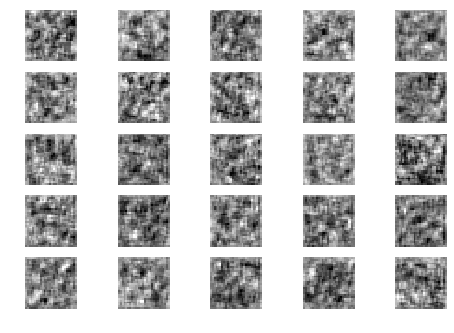

Epoch 2 Batch 506/937 [D loss: 0.548948, acc.: 71.88%] [G loss: 1.272376]
Epoch 2 Batch 507/937 [D loss: 0.685243, acc.: 59.38%] [G loss: 0.803241]
Epoch 2 Batch 508/937 [D loss: 0.730527, acc.: 53.12%] [G loss: 1.149473]
Epoch 2 Batch 509/937 [D loss: 0.496763, acc.: 78.12%] [G loss: 1.296127]
Epoch 2 Batch 510/937 [D loss: 0.459626, acc.: 81.25%] [G loss: 1.240919]


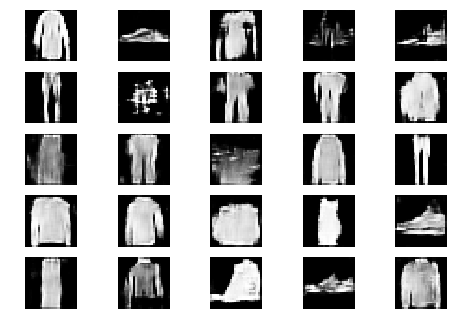

Epoch 2 Batch 511/937 [D loss: 0.652409, acc.: 62.50%] [G loss: 1.125240]
Epoch 2 Batch 512/937 [D loss: 0.572036, acc.: 71.88%] [G loss: 1.101021]
Epoch 2 Batch 513/937 [D loss: 0.504950, acc.: 68.75%] [G loss: 1.167264]
Epoch 2 Batch 514/937 [D loss: 0.735272, acc.: 59.38%] [G loss: 0.977227]
Epoch 2 Batch 515/937 [D loss: 0.635024, acc.: 59.38%] [G loss: 1.101313]
Epoch 2 Batch 516/937 [D loss: 0.676774, acc.: 68.75%] [G loss: 0.777292]
Epoch 2 Batch 517/937 [D loss: 0.450877, acc.: 78.12%] [G loss: 0.982083]
Epoch 2 Batch 518/937 [D loss: 0.571577, acc.: 78.12%] [G loss: 1.175822]
Epoch 2 Batch 519/937 [D loss: 0.604179, acc.: 68.75%] [G loss: 1.177693]
Epoch 2 Batch 520/937 [D loss: 0.707985, acc.: 56.25%] [G loss: 1.010558]
Epoch 2 Batch 521/937 [D loss: 0.734136, acc.: 56.25%] [G loss: 1.188944]
Epoch 2 Batch 522/937 [D loss: 0.546952, acc.: 71.88%] [G loss: 1.032048]
Epoch 2 Batch 523/937 [D loss: 0.648426, acc.: 56.25%] [G loss: 1.068471]
Epoch 2 Batch 524/937 [D loss: 0.51568

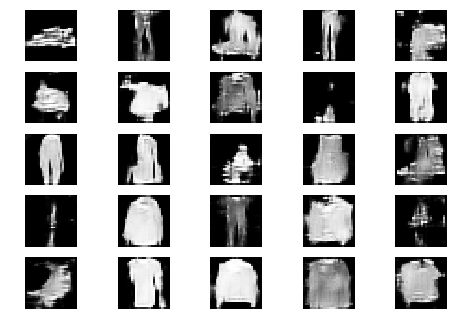

Epoch 2 Batch 601/937 [D loss: 0.635506, acc.: 62.50%] [G loss: 1.275367]
Epoch 2 Batch 602/937 [D loss: 0.555036, acc.: 81.25%] [G loss: 1.324149]
Epoch 2 Batch 603/937 [D loss: 0.487582, acc.: 71.88%] [G loss: 1.152216]
Epoch 2 Batch 604/937 [D loss: 0.649595, acc.: 68.75%] [G loss: 1.144987]
Epoch 2 Batch 605/937 [D loss: 0.499290, acc.: 78.12%] [G loss: 1.242747]
Epoch 2 Batch 606/937 [D loss: 0.613246, acc.: 65.62%] [G loss: 0.978215]


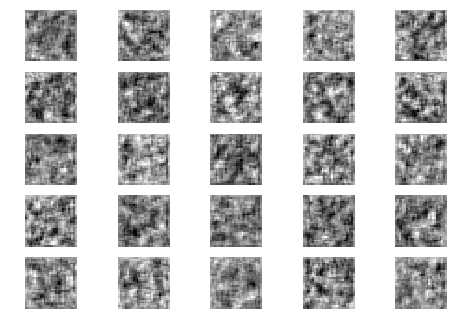

Epoch 2 Batch 607/937 [D loss: 0.596763, acc.: 65.62%] [G loss: 1.217890]
Epoch 2 Batch 608/937 [D loss: 0.651115, acc.: 59.38%] [G loss: 1.203678]
Epoch 2 Batch 609/937 [D loss: 0.581133, acc.: 68.75%] [G loss: 0.843458]
Epoch 2 Batch 610/937 [D loss: 0.437367, acc.: 81.25%] [G loss: 1.183635]
Epoch 2 Batch 611/937 [D loss: 0.671377, acc.: 65.62%] [G loss: 1.191954]
Epoch 2 Batch 612/937 [D loss: 0.641112, acc.: 59.38%] [G loss: 1.165966]


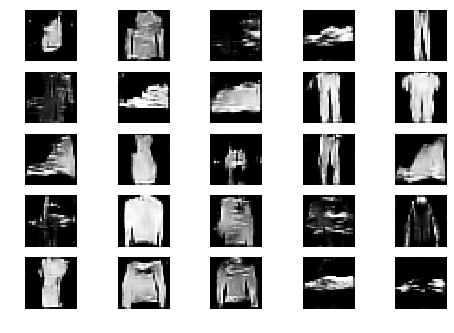

Epoch 2 Batch 613/937 [D loss: 0.675715, acc.: 53.12%] [G loss: 1.053773]
Epoch 2 Batch 614/937 [D loss: 0.674092, acc.: 65.62%] [G loss: 1.066307]
Epoch 2 Batch 615/937 [D loss: 0.592609, acc.: 71.88%] [G loss: 1.294792]
Epoch 2 Batch 616/937 [D loss: 0.579788, acc.: 68.75%] [G loss: 1.288352]
Epoch 2 Batch 617/937 [D loss: 1.079471, acc.: 34.38%] [G loss: 1.061931]
Epoch 2 Batch 618/937 [D loss: 0.541667, acc.: 68.75%] [G loss: 1.189014]
Epoch 2 Batch 619/937 [D loss: 0.536663, acc.: 78.12%] [G loss: 1.069165]
Epoch 2 Batch 620/937 [D loss: 0.487727, acc.: 84.38%] [G loss: 1.237117]
Epoch 2 Batch 621/937 [D loss: 0.624476, acc.: 75.00%] [G loss: 1.024481]
Epoch 2 Batch 622/937 [D loss: 0.504389, acc.: 84.38%] [G loss: 1.116641]
Epoch 2 Batch 623/937 [D loss: 0.766477, acc.: 56.25%] [G loss: 1.030360]
Epoch 2 Batch 624/937 [D loss: 0.475600, acc.: 87.50%] [G loss: 1.243570]
Epoch 2 Batch 625/937 [D loss: 0.580537, acc.: 71.88%] [G loss: 1.158874]
Epoch 2 Batch 626/937 [D loss: 0.68951

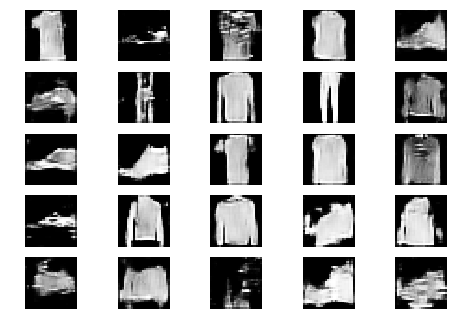

Epoch 2 Batch 701/937 [D loss: 0.581012, acc.: 68.75%] [G loss: 1.259478]
Epoch 2 Batch 702/937 [D loss: 0.718512, acc.: 62.50%] [G loss: 1.165608]
Epoch 2 Batch 703/937 [D loss: 0.539558, acc.: 68.75%] [G loss: 1.082899]
Epoch 2 Batch 704/937 [D loss: 0.717301, acc.: 62.50%] [G loss: 1.110885]
Epoch 2 Batch 705/937 [D loss: 0.646760, acc.: 71.88%] [G loss: 1.189838]
Epoch 2 Batch 706/937 [D loss: 0.608568, acc.: 65.62%] [G loss: 0.957035]
Epoch 2 Batch 707/937 [D loss: 0.665427, acc.: 65.62%] [G loss: 1.065210]


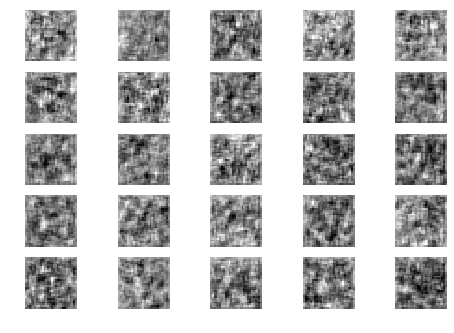

Epoch 2 Batch 708/937 [D loss: 0.611318, acc.: 59.38%] [G loss: 0.978621]
Epoch 2 Batch 709/937 [D loss: 0.688705, acc.: 53.12%] [G loss: 1.107571]
Epoch 2 Batch 710/937 [D loss: 0.573270, acc.: 71.88%] [G loss: 1.015461]
Epoch 2 Batch 711/937 [D loss: 0.740051, acc.: 59.38%] [G loss: 1.154900]
Epoch 2 Batch 712/937 [D loss: 0.543702, acc.: 71.88%] [G loss: 1.536601]
Epoch 2 Batch 713/937 [D loss: 0.669548, acc.: 68.75%] [G loss: 1.175274]
Epoch 2 Batch 714/937 [D loss: 0.556714, acc.: 68.75%] [G loss: 0.867704]


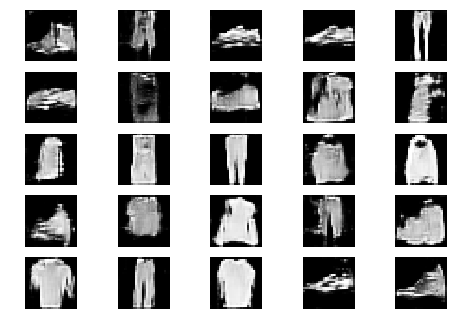

Epoch 2 Batch 715/937 [D loss: 0.637519, acc.: 65.62%] [G loss: 0.946659]
Epoch 2 Batch 716/937 [D loss: 0.653067, acc.: 62.50%] [G loss: 0.900239]
Epoch 2 Batch 717/937 [D loss: 0.657998, acc.: 65.62%] [G loss: 1.124977]
Epoch 2 Batch 718/937 [D loss: 0.593790, acc.: 65.62%] [G loss: 1.161367]
Epoch 2 Batch 719/937 [D loss: 0.598592, acc.: 71.88%] [G loss: 1.307857]
Epoch 2 Batch 720/937 [D loss: 0.620907, acc.: 75.00%] [G loss: 1.065828]
Epoch 2 Batch 721/937 [D loss: 0.588711, acc.: 65.62%] [G loss: 0.985825]
Epoch 2 Batch 722/937 [D loss: 0.593144, acc.: 71.88%] [G loss: 1.029161]
Epoch 2 Batch 723/937 [D loss: 0.727884, acc.: 56.25%] [G loss: 1.210110]
Epoch 2 Batch 724/937 [D loss: 0.912298, acc.: 43.75%] [G loss: 1.159374]
Epoch 2 Batch 725/937 [D loss: 0.564099, acc.: 71.88%] [G loss: 1.269466]
Epoch 2 Batch 726/937 [D loss: 0.665779, acc.: 53.12%] [G loss: 1.134534]
Epoch 2 Batch 727/937 [D loss: 0.675961, acc.: 56.25%] [G loss: 1.147918]
Epoch 2 Batch 728/937 [D loss: 0.68397

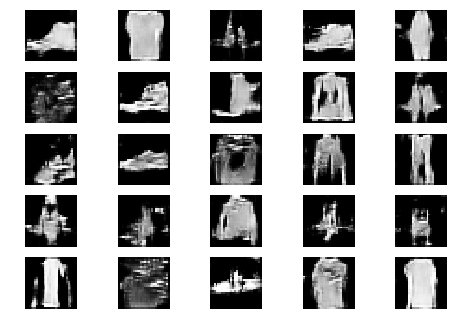

Epoch 2 Batch 801/937 [D loss: 0.656199, acc.: 65.62%] [G loss: 0.911374]
Epoch 2 Batch 802/937 [D loss: 0.676362, acc.: 62.50%] [G loss: 1.153567]
Epoch 2 Batch 803/937 [D loss: 0.842815, acc.: 50.00%] [G loss: 0.948858]
Epoch 2 Batch 804/937 [D loss: 0.660444, acc.: 56.25%] [G loss: 1.105117]
Epoch 2 Batch 805/937 [D loss: 0.608053, acc.: 65.62%] [G loss: 1.263174]
Epoch 2 Batch 806/937 [D loss: 0.695002, acc.: 62.50%] [G loss: 1.245393]
Epoch 2 Batch 807/937 [D loss: 0.867683, acc.: 46.88%] [G loss: 1.088374]
Epoch 2 Batch 808/937 [D loss: 0.606834, acc.: 68.75%] [G loss: 1.372554]


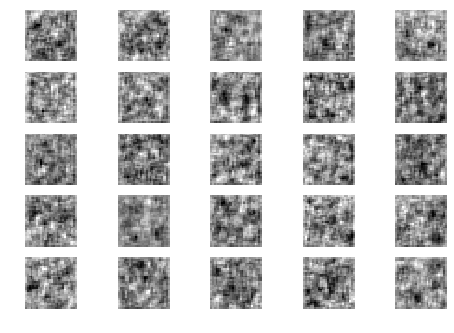

Epoch 2 Batch 809/937 [D loss: 0.576571, acc.: 68.75%] [G loss: 1.421672]
Epoch 2 Batch 810/937 [D loss: 0.516706, acc.: 71.88%] [G loss: 0.982148]
Epoch 2 Batch 811/937 [D loss: 0.537600, acc.: 78.12%] [G loss: 1.040153]
Epoch 2 Batch 812/937 [D loss: 0.549436, acc.: 71.88%] [G loss: 0.933831]
Epoch 2 Batch 813/937 [D loss: 0.712742, acc.: 65.62%] [G loss: 1.078031]
Epoch 2 Batch 814/937 [D loss: 0.824414, acc.: 53.12%] [G loss: 1.186336]
Epoch 2 Batch 815/937 [D loss: 0.682406, acc.: 65.62%] [G loss: 1.581128]
Epoch 2 Batch 816/937 [D loss: 0.566519, acc.: 65.62%] [G loss: 1.118273]


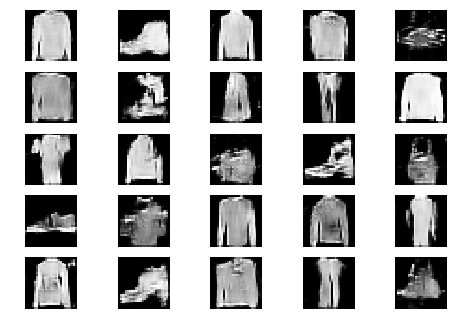

Epoch 2 Batch 817/937 [D loss: 0.812588, acc.: 53.12%] [G loss: 1.321989]
Epoch 2 Batch 818/937 [D loss: 0.715125, acc.: 56.25%] [G loss: 0.964494]
Epoch 2 Batch 819/937 [D loss: 0.696377, acc.: 53.12%] [G loss: 1.179559]
Epoch 2 Batch 820/937 [D loss: 0.663755, acc.: 68.75%] [G loss: 0.860678]
Epoch 2 Batch 821/937 [D loss: 0.606107, acc.: 68.75%] [G loss: 0.911839]
Epoch 2 Batch 822/937 [D loss: 0.700476, acc.: 50.00%] [G loss: 1.230004]
Epoch 2 Batch 823/937 [D loss: 0.427190, acc.: 84.38%] [G loss: 0.979394]
Epoch 2 Batch 824/937 [D loss: 0.700327, acc.: 59.38%] [G loss: 1.125490]
Epoch 2 Batch 825/937 [D loss: 0.633775, acc.: 65.62%] [G loss: 1.216113]
Epoch 2 Batch 826/937 [D loss: 0.748074, acc.: 53.12%] [G loss: 0.888803]
Epoch 2 Batch 827/937 [D loss: 0.638202, acc.: 53.12%] [G loss: 1.048911]
Epoch 2 Batch 828/937 [D loss: 0.459816, acc.: 78.12%] [G loss: 1.157094]
Epoch 2 Batch 829/937 [D loss: 0.647223, acc.: 62.50%] [G loss: 1.064169]
Epoch 2 Batch 830/937 [D loss: 0.61583

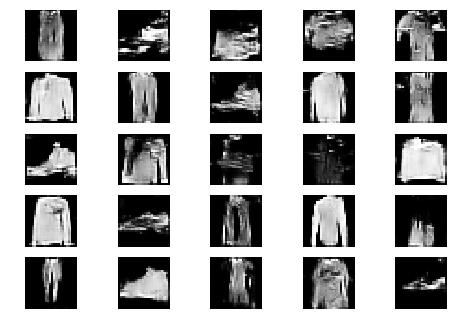

Epoch 2 Batch 901/937 [D loss: 0.545633, acc.: 62.50%] [G loss: 1.152717]
Epoch 2 Batch 902/937 [D loss: 0.525482, acc.: 75.00%] [G loss: 0.997621]
Epoch 2 Batch 903/937 [D loss: 0.681633, acc.: 56.25%] [G loss: 1.073165]
Epoch 2 Batch 904/937 [D loss: 0.599834, acc.: 71.88%] [G loss: 1.370215]
Epoch 2 Batch 905/937 [D loss: 0.551532, acc.: 62.50%] [G loss: 1.277630]
Epoch 2 Batch 906/937 [D loss: 0.572469, acc.: 75.00%] [G loss: 0.882029]
Epoch 2 Batch 907/937 [D loss: 0.575938, acc.: 71.88%] [G loss: 0.949499]
Epoch 2 Batch 908/937 [D loss: 0.679889, acc.: 56.25%] [G loss: 0.981283]
Epoch 2 Batch 909/937 [D loss: 0.637890, acc.: 65.62%] [G loss: 1.198727]


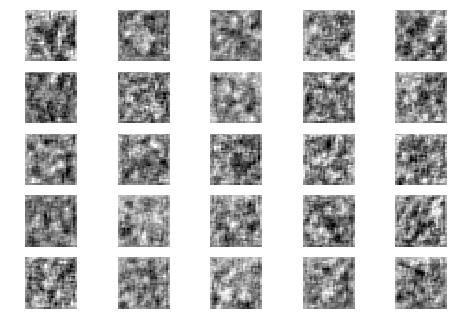

Epoch 2 Batch 910/937 [D loss: 0.576620, acc.: 65.62%] [G loss: 1.139404]
Epoch 2 Batch 911/937 [D loss: 0.743357, acc.: 65.62%] [G loss: 1.137483]
Epoch 2 Batch 912/937 [D loss: 0.513541, acc.: 75.00%] [G loss: 1.054638]
Epoch 2 Batch 913/937 [D loss: 0.599758, acc.: 65.62%] [G loss: 1.123244]
Epoch 2 Batch 914/937 [D loss: 0.642521, acc.: 56.25%] [G loss: 1.086836]
Epoch 2 Batch 915/937 [D loss: 0.734009, acc.: 50.00%] [G loss: 1.087884]
Epoch 2 Batch 916/937 [D loss: 0.606303, acc.: 65.62%] [G loss: 0.963478]
Epoch 2 Batch 917/937 [D loss: 0.639288, acc.: 50.00%] [G loss: 1.050056]
Epoch 2 Batch 918/937 [D loss: 0.631051, acc.: 62.50%] [G loss: 1.154788]


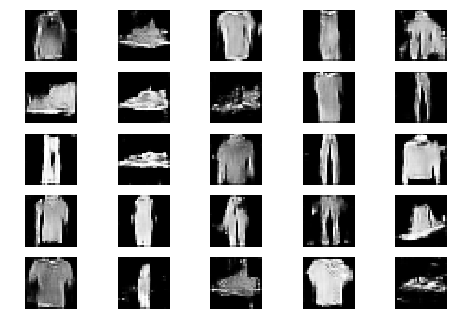

Epoch 2 Batch 919/937 [D loss: 0.621755, acc.: 62.50%] [G loss: 1.203186]
Epoch 2 Batch 920/937 [D loss: 0.658698, acc.: 56.25%] [G loss: 1.176882]
Epoch 2 Batch 921/937 [D loss: 0.808651, acc.: 50.00%] [G loss: 0.970906]
Epoch 2 Batch 922/937 [D loss: 0.582125, acc.: 62.50%] [G loss: 0.977270]
Epoch 2 Batch 923/937 [D loss: 0.637301, acc.: 62.50%] [G loss: 1.182034]
Epoch 2 Batch 924/937 [D loss: 0.532687, acc.: 71.88%] [G loss: 1.003497]
Epoch 2 Batch 925/937 [D loss: 0.588282, acc.: 68.75%] [G loss: 0.999707]
Epoch 2 Batch 926/937 [D loss: 0.718052, acc.: 56.25%] [G loss: 1.111701]
Epoch 2 Batch 927/937 [D loss: 0.587621, acc.: 68.75%] [G loss: 1.038665]
Epoch 2 Batch 928/937 [D loss: 0.728532, acc.: 56.25%] [G loss: 0.993298]
Epoch 2 Batch 929/937 [D loss: 0.565076, acc.: 68.75%] [G loss: 0.856105]
Epoch 2 Batch 930/937 [D loss: 0.614017, acc.: 65.62%] [G loss: 0.989581]
Epoch 2 Batch 931/937 [D loss: 0.755622, acc.: 59.38%] [G loss: 1.296373]
Epoch 2 Batch 932/937 [D loss: 0.68482

In [13]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
plotamodel(combined)
files.download('model.png')




In [0]:
#train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
!rm -rf generator1fminst.h5



In [0]:

generator1.save('generator1fminst.h5')



In [0]:
files.download('generator1fminst.h5')


In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


Number of examples:  30000.0
Number of Batches:  937
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/937 [D loss: 0.678467, acc.: 65.62%] [G loss: 0.878855]


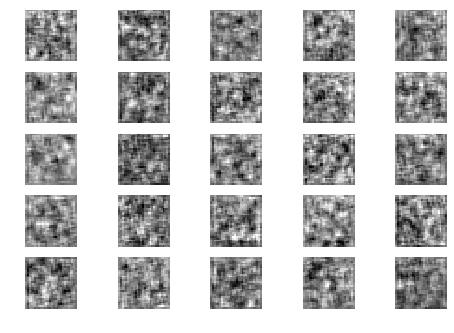

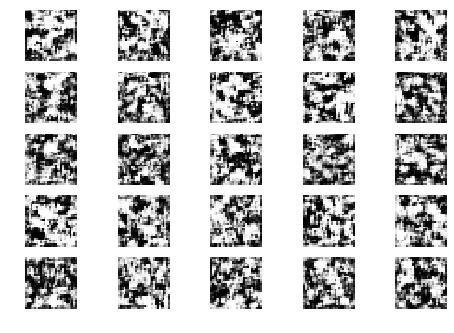

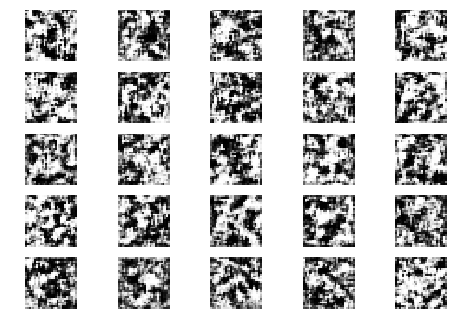

Epoch 0 Batch 1/937 [D loss: 0.588369, acc.: 71.88%] [G loss: 0.838591]
Epoch 0 Batch 2/937 [D loss: 0.699005, acc.: 59.38%] [G loss: 0.841357]
Epoch 0 Batch 3/937 [D loss: 0.458925, acc.: 84.38%] [G loss: 1.118056]
Epoch 0 Batch 4/937 [D loss: 0.443337, acc.: 84.38%] [G loss: 1.020184]
Epoch 0 Batch 5/937 [D loss: 0.391167, acc.: 81.25%] [G loss: 1.200273]
Epoch 0 Batch 6/937 [D loss: 0.425851, acc.: 78.12%] [G loss: 1.360677]
Epoch 0 Batch 7/937 [D loss: 0.483908, acc.: 71.88%] [G loss: 1.427846]
Epoch 0 Batch 8/937 [D loss: 0.420496, acc.: 78.12%] [G loss: 1.363683]
Epoch 0 Batch 9/937 [D loss: 0.488952, acc.: 81.25%] [G loss: 1.662857]
Epoch 0 Batch 10/937 [D loss: 0.570098, acc.: 68.75%] [G loss: 1.276299]
Epoch 0 Batch 11/937 [D loss: 0.385358, acc.: 87.50%] [G loss: 1.553005]
Epoch 0 Batch 12/937 [D loss: 0.345115, acc.: 84.38%] [G loss: 1.690642]
Epoch 0 Batch 13/937 [D loss: 0.415593, acc.: 87.50%] [G loss: 1.614090]
Epoch 0 Batch 14/937 [D loss: 0.397906, acc.: 81.25%] [G los

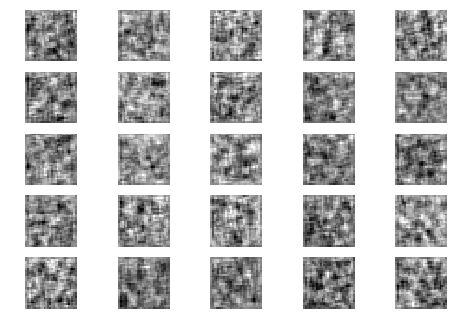

Epoch 0 Batch 101/937 [D loss: 0.457355, acc.: 81.25%] [G loss: 1.514925]


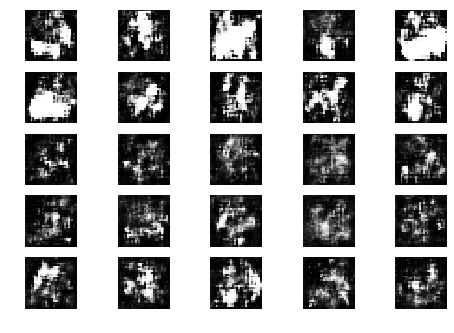

Epoch 0 Batch 102/937 [D loss: 0.624028, acc.: 71.88%] [G loss: 1.604146]


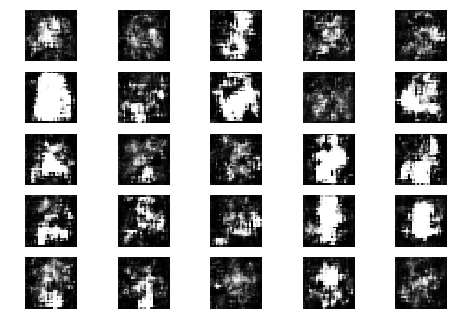

Epoch 0 Batch 103/937 [D loss: 0.496272, acc.: 78.12%] [G loss: 2.448229]
Epoch 0 Batch 104/937 [D loss: 0.544091, acc.: 78.12%] [G loss: 1.958826]
Epoch 0 Batch 105/937 [D loss: 0.752119, acc.: 59.38%] [G loss: 1.311256]
Epoch 0 Batch 106/937 [D loss: 0.344675, acc.: 87.50%] [G loss: 1.583001]
Epoch 0 Batch 107/937 [D loss: 0.384727, acc.: 75.00%] [G loss: 2.218238]
Epoch 0 Batch 108/937 [D loss: 0.869927, acc.: 56.25%] [G loss: 1.245557]
Epoch 0 Batch 109/937 [D loss: 0.789415, acc.: 53.12%] [G loss: 1.588262]
Epoch 0 Batch 110/937 [D loss: 0.774530, acc.: 71.88%] [G loss: 1.565698]
Epoch 0 Batch 111/937 [D loss: 0.377013, acc.: 87.50%] [G loss: 2.100635]
Epoch 0 Batch 112/937 [D loss: 0.561055, acc.: 78.12%] [G loss: 1.869653]
Epoch 0 Batch 113/937 [D loss: 0.749079, acc.: 62.50%] [G loss: 1.427249]
Epoch 0 Batch 114/937 [D loss: 0.445765, acc.: 78.12%] [G loss: 1.870292]
Epoch 0 Batch 115/937 [D loss: 0.502301, acc.: 75.00%] [G loss: 1.920181]
Epoch 0 Batch 116/937 [D loss: 0.48341

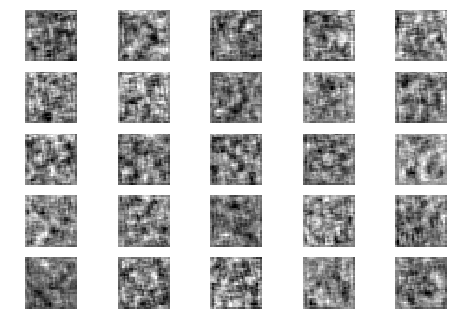

Epoch 0 Batch 201/937 [D loss: 0.679053, acc.: 65.62%] [G loss: 1.290563]
Epoch 0 Batch 202/937 [D loss: 0.488489, acc.: 75.00%] [G loss: 1.438135]


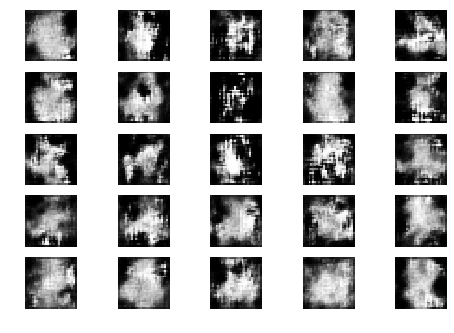

Epoch 0 Batch 203/937 [D loss: 1.115075, acc.: 46.88%] [G loss: 1.512763]
Epoch 0 Batch 204/937 [D loss: 0.612922, acc.: 71.88%] [G loss: 1.404377]


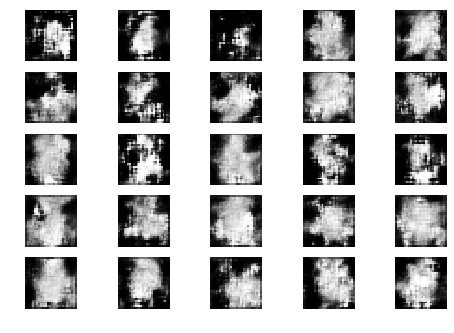

Epoch 0 Batch 205/937 [D loss: 0.620278, acc.: 71.88%] [G loss: 1.624096]
Epoch 0 Batch 206/937 [D loss: 0.633549, acc.: 78.12%] [G loss: 1.374520]
Epoch 0 Batch 207/937 [D loss: 0.648082, acc.: 65.62%] [G loss: 1.296136]
Epoch 0 Batch 208/937 [D loss: 0.787903, acc.: 59.38%] [G loss: 1.139998]
Epoch 0 Batch 209/937 [D loss: 0.467986, acc.: 84.38%] [G loss: 1.360461]
Epoch 0 Batch 210/937 [D loss: 0.738355, acc.: 65.62%] [G loss: 1.210830]
Epoch 0 Batch 211/937 [D loss: 0.597378, acc.: 59.38%] [G loss: 1.117395]
Epoch 0 Batch 212/937 [D loss: 0.784160, acc.: 62.50%] [G loss: 1.221292]
Epoch 0 Batch 213/937 [D loss: 0.590839, acc.: 62.50%] [G loss: 1.877246]
Epoch 0 Batch 214/937 [D loss: 0.814660, acc.: 56.25%] [G loss: 1.360065]
Epoch 0 Batch 215/937 [D loss: 0.652383, acc.: 71.88%] [G loss: 1.556737]
Epoch 0 Batch 216/937 [D loss: 0.555282, acc.: 71.88%] [G loss: 1.461262]
Epoch 0 Batch 217/937 [D loss: 0.742808, acc.: 59.38%] [G loss: 1.586575]
Epoch 0 Batch 218/937 [D loss: 0.71614

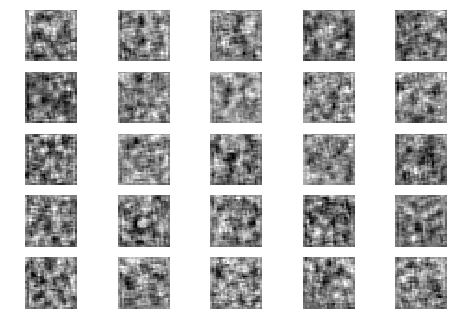

Epoch 0 Batch 301/937 [D loss: 0.538814, acc.: 71.88%] [G loss: 1.856560]
Epoch 0 Batch 302/937 [D loss: 0.748849, acc.: 62.50%] [G loss: 1.096242]
Epoch 0 Batch 303/937 [D loss: 0.563283, acc.: 68.75%] [G loss: 1.342204]


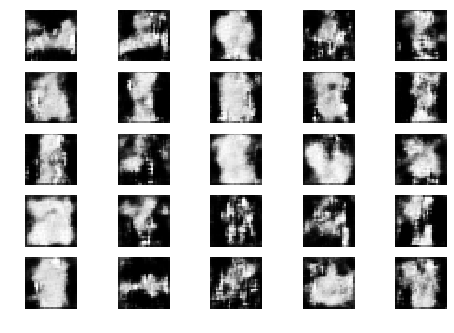

Epoch 0 Batch 304/937 [D loss: 0.514517, acc.: 78.12%] [G loss: 1.591603]
Epoch 0 Batch 305/937 [D loss: 0.678191, acc.: 65.62%] [G loss: 1.552708]
Epoch 0 Batch 306/937 [D loss: 0.663042, acc.: 62.50%] [G loss: 1.469136]


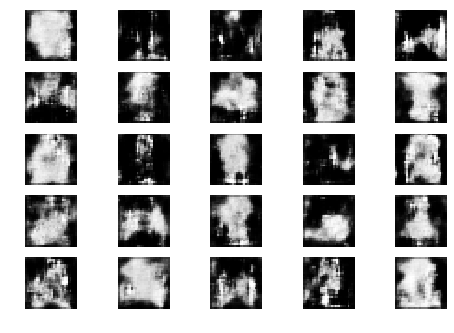

Epoch 0 Batch 307/937 [D loss: 0.523031, acc.: 71.88%] [G loss: 1.947076]
Epoch 0 Batch 308/937 [D loss: 0.563179, acc.: 71.88%] [G loss: 1.305073]
Epoch 0 Batch 309/937 [D loss: 0.733258, acc.: 56.25%] [G loss: 1.207924]
Epoch 0 Batch 310/937 [D loss: 0.610586, acc.: 71.88%] [G loss: 1.649599]
Epoch 0 Batch 311/937 [D loss: 0.572122, acc.: 65.62%] [G loss: 1.280895]
Epoch 0 Batch 312/937 [D loss: 0.406343, acc.: 90.62%] [G loss: 1.462400]
Epoch 0 Batch 313/937 [D loss: 0.641970, acc.: 62.50%] [G loss: 1.430537]
Epoch 0 Batch 314/937 [D loss: 0.741456, acc.: 68.75%] [G loss: 1.329866]
Epoch 0 Batch 315/937 [D loss: 0.897764, acc.: 53.12%] [G loss: 1.592570]
Epoch 0 Batch 316/937 [D loss: 0.682998, acc.: 59.38%] [G loss: 1.794743]
Epoch 0 Batch 317/937 [D loss: 0.744901, acc.: 65.62%] [G loss: 1.648138]
Epoch 0 Batch 318/937 [D loss: 0.492393, acc.: 81.25%] [G loss: 1.194363]
Epoch 0 Batch 319/937 [D loss: 0.630062, acc.: 65.62%] [G loss: 1.379674]
Epoch 0 Batch 320/937 [D loss: 0.63937

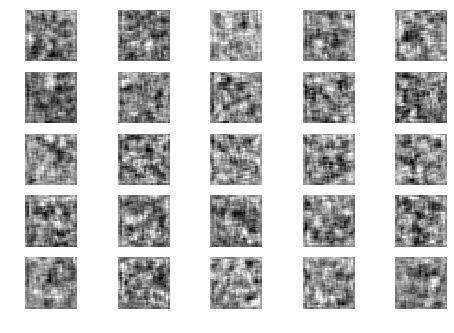

Epoch 0 Batch 401/937 [D loss: 0.618971, acc.: 75.00%] [G loss: 1.217901]
Epoch 0 Batch 402/937 [D loss: 0.532966, acc.: 81.25%] [G loss: 1.875029]
Epoch 0 Batch 403/937 [D loss: 0.540965, acc.: 78.12%] [G loss: 1.635972]
Epoch 0 Batch 404/937 [D loss: 0.442703, acc.: 81.25%] [G loss: 1.875144]


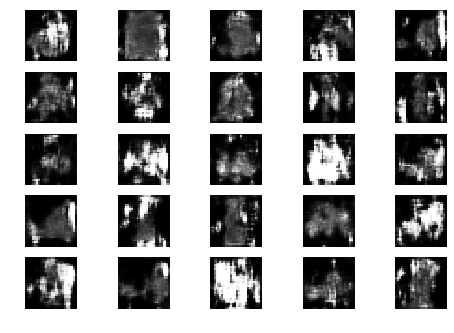

Epoch 0 Batch 405/937 [D loss: 0.442655, acc.: 71.88%] [G loss: 1.703774]
Epoch 0 Batch 406/937 [D loss: 0.698471, acc.: 71.88%] [G loss: 1.646174]
Epoch 0 Batch 407/937 [D loss: 0.559327, acc.: 65.62%] [G loss: 1.694405]
Epoch 0 Batch 408/937 [D loss: 0.746779, acc.: 68.75%] [G loss: 1.217504]


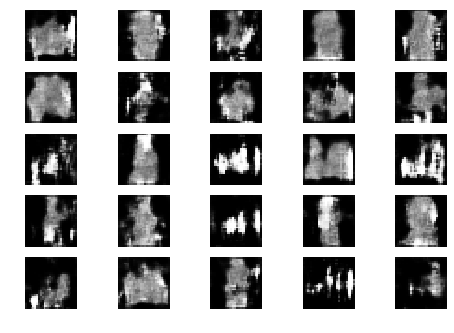

Epoch 0 Batch 409/937 [D loss: 0.531692, acc.: 71.88%] [G loss: 1.369419]
Epoch 0 Batch 410/937 [D loss: 0.470189, acc.: 78.12%] [G loss: 1.400952]
Epoch 0 Batch 411/937 [D loss: 0.634661, acc.: 68.75%] [G loss: 1.468677]
Epoch 0 Batch 412/937 [D loss: 0.736206, acc.: 62.50%] [G loss: 1.275440]
Epoch 0 Batch 413/937 [D loss: 0.719631, acc.: 62.50%] [G loss: 1.734796]
Epoch 0 Batch 414/937 [D loss: 0.779510, acc.: 56.25%] [G loss: 1.579539]
Epoch 0 Batch 415/937 [D loss: 0.757884, acc.: 56.25%] [G loss: 1.369411]
Epoch 0 Batch 416/937 [D loss: 0.586884, acc.: 68.75%] [G loss: 1.508256]
Epoch 0 Batch 417/937 [D loss: 0.658144, acc.: 59.38%] [G loss: 1.416162]
Epoch 0 Batch 418/937 [D loss: 0.432514, acc.: 87.50%] [G loss: 1.514591]
Epoch 0 Batch 419/937 [D loss: 0.617468, acc.: 65.62%] [G loss: 1.627902]
Epoch 0 Batch 420/937 [D loss: 0.729831, acc.: 62.50%] [G loss: 1.682499]
Epoch 0 Batch 421/937 [D loss: 0.616542, acc.: 62.50%] [G loss: 1.466142]
Epoch 0 Batch 422/937 [D loss: 0.47544

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=20, modeltotrain=2)

In [0]:
!rm -rf generator2fmnist.h5


In [0]:

generator2.save('generator2fmnist.h5')

In [26]:
!ls -al


total 97520
drwxr-xr-x 1 root root     4096 Dec  5 13:25 .
drwxr-xr-x 1 root root     4096 Dec  5 05:42 ..
-rw-r--r-- 1 root root 22256168 Dec  5 08:34 combined1.h5
drwxr-xr-x 1 root root     4096 Dec  3 17:43 .config
-rw-r--r-- 1 root root 15348832 Dec  5 08:34 discriminator1.h5
-rw-r--r-- 1 root root 10336800 Dec  5 12:12 generator1fminst2.h5
-rw-r--r-- 1 root root 10336816 Dec  5 13:27 generator1fminst.h5
-rw-r--r-- 1 root root    55406 Dec  5 09:40 generator1.h5
-rw-r--r-- 1 root root    55407 Dec  5 08:35 generator1.h5.1
-rw-r--r-- 1 root root 10336800 Dec  5 08:35 generator1.h5.2
-rw-r--r-- 1 root root 10336824 Dec  5 12:26 generator2fmnist.h5
-rw-r--r-- 1 root root 10336800 Dec  5 09:05 generatorTrained1.h5
-rw-r--r-- 1 root root 10336800 Dec  5 10:25 generatorTrainedepoch2git.h5
-rw-r--r-- 1 root root    33975 Dec  5 13:24 model.png
-rw-r--r-- 1 root root    33975 Dec  5 13:25 modelsmall.png
drwxr-xr-x 2 root root     4096 Dec  3 17:43 sample_data


In [0]:
!ls -al

In [0]:
##!wget https://github.com/rajagopalmotivate/try1/raw/master/generatorTrainedepoch2git.h5

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=1)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
plotamodel(combined)
files.download('model.png')

In [0]:
!rm -rf generatorTrainedepoch2.h5

generator1.save('generator1fminst.h5')

!rm -rf generator2Trainedepoch2.h5

generator2.save('generator2fminst.h5')


In [0]:
generator1 = generator1.load_weights('generator1fmnist.h5')

In [0]:
generator2 = generator2.load_weights('generator2fmnist.h5')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
generator1.save('generatorTrained1epoch4.h5')

In [22]:
files.download('generator1fmnist.h5')

FileNotFoundError: ignored

In [0]:
files.download('generator2fmnist.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

